<body>
    <div>
        <center>
            <br>
            <h1><b>Hyperpartisan news detection</b></h1>
            <h3><b>16.04.2021</b></h3>
            <br>
            <h2><b><u>HyperNews</u></b></h2>
            <h4><b>Rza Behbudov</b></h4> 
            <h4><b>Ronny Wathne</b></h4> 
            <h4><b>Muhammad Ali Anwar</b></h4> 
            <h4><b>Christoffer Andersen Gabrielsen</b></h4> 
            <br>
        </center>
    </div>
</body>

# Project Guidelines
https://github.com/dat550-2021/course-info/blob/master/project_guidelines.md

## Dependencies

Files which is needed to download and extracted in the same folder as HyperNews.ipynb
https://archive.org/details/partisan-news-facebook-posts-2015-01-01-to-2017-03-31



Other csv files will be downloaded from this url when function is executed
-    https://github.com/BuzzFeedNews/2017-08-partisan-sites-and-facebook-pages/blob/master/data/

### Libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
import gc
import nltk
import seaborn as sns
from nltk import ngrams
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report,accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.utils import class_weight
from sklearn.utils.extmath import density
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from scipy.stats import normaltest, ttest_ind, ks_2samp, ttest_rel, wilcoxon
from mlxtend.evaluate import paired_ttest_5x2cv

#setting random seed
np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rzbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing Data

Reading dataset containing the political category

In [2]:
partisan_sites_url = "https://raw.githubusercontent.com/BuzzFeedNews/2017-08-partisan-sites-and-facebook-pages/master/data/all-partisan-sites.csv"
partisan_sites = pd.read_csv(partisan_sites_url,sep=",",dtype={ "fb_id": str , "unavailable_id":str}).fillna("None")
partisan_sites[354:].head()

site political_category            fb_id  \
354    newsdiscoverer.com              right      unavailable   
355  newsflashonline.info              right             None   
356  newsfrompolitics.com              right      unavailable   
357         newshounds.us               left  144344708930358   
358          newsleaks.co              right      unavailable   

      unavailable_id  macedonian  
354  499590466904637           1  
355             None           1  
356  524812664343513           1  
357             None           0  
358  490751094464993           0

The column "unavailable_id" contains the facebook id which was not provided from Facebooks API during Buzzfeeds initial request. We will merge these values with "fb_id" if missing

In [3]:
dup = partisan_sites.unavailable_id != "None"
partisan_sites.loc[dup,"fb_id"] = partisan_sites.unavailable_id[dup]
partisan_sites.drop("unavailable_id",axis=1,inplace=True)
partisan_sites = partisan_sites[~partisan_sites.fb_id.isin(["None", "unavailable", "personal_page" ])]

Checking for duplicates

In [4]:
print(f"There are {len(partisan_sites[partisan_sites.fb_id.duplicated(keep=False)])} entries with the same fb_id")
partisan_sites[partisan_sites.fb_id.duplicated(keep=False)].sort_values("fb_id").head()

There are 83 entries with the same fb_id


site political_category             fb_id  \
649           viralpatriots.com              right  1065157933581240   
645        viraldeplorables.com              right  1065157933581240   
523     thedailydeplorables.com              right  1065157933581240   
525        thedailypatriots.com              right  1065157933581240   
116  conservativedeplorable.com              right  1065157933581240   

     macedonian  
649           0  
645           0  
523           0  
525           0  
116           0

Checking if the duplicates has different political categories

In [5]:
pol_cat = partisan_sites.groupby("fb_id")["political_category"]
print(f"There are {(pol_cat.nunique() > 1).sum()} duplicates in the dataframe with different political categories")

There are 0 duplicates in the dataframe with different political categories


Since there is several sites with the same fb_id we will group fb_id by the political_category then we will merge these with page_name from pages-info.csv

In [6]:
pages_info_url = "https://raw.githubusercontent.com/BuzzFeedNews/2017-08-partisan-sites-and-facebook-pages/master/data/pages-info.csv"
pages_info = pd.read_csv(pages_info_url,sep=",",dtype={ "page_id": str}).fillna("None")
pages_info.head()

page_name  \
0             Americans Against the Tea Party   
1                                      act.tv   
2                             New Blue United   
3  Obama is the Worst President in US History   
4                            RedFlag NewsDesk   

                                               about  fan_count  \
0      We are your go to source for political news.      583256   
1  Rise up and Resist! Your home for movement-ori...     285075   
2                                               None    1476093   
3                                               None    1569590   
4  Daily headlines from the official RedFlagNews....       1533   

   talking_about_count                 website          page_id    year month  \
0                43343    http://www.aattp.org  108038612554992  2009.0   4.0   
1               481748           http://act.tv  153418591515382    None  None   
2                93116     www.bluetribune.com  188464111175168    None  None   
3                41452                    None  296856040436954  2013.0   1.0   
4                   76  http://redflagnews.com  492836854251934  2016.0   3.0   

    day  
0   3.0  
1  None  
2  None  
3   1.0  
4  16.0

In [7]:
#We will use these columns, we can add more from above if we want to use it for analysis
col = ["page_id", "page_name"]

page_cat = pd.merge(pages_info[col],pol_cat.first().reset_index().rename(columns={"fb_id": "page_id"}),on = "page_id")
page_cat.head()

page_id                                   page_name  \
0  108038612554992             Americans Against the Tea Party   
1  153418591515382                                      act.tv   
2  188464111175168                             New Blue United   
3  296856040436954  Obama is the Worst President in US History   
4  492836854251934                            RedFlag NewsDesk   

  political_category  
0               left  
1               left  
2               left  
3              right  
4              right

Loading facebook status dataset merging it to get the classification for each post

In [8]:
def readingstatuses(path):
    """
    Function to load the data from disk
    """
    filenames = [f for f in os.listdir(statuspath) if f.endswith(".csv")] #getting filename for every .csv file
    for filename in filenames:
        status = pd.read_csv(path+os.sep+filename).fillna("None")
        status["status_published"] = pd.to_datetime(status["status_published"]).dt.date #Parsing string to datetime format
        status["page_id"] = filename.split("_")[0] #Getting the page_id from the filename
        yield status

In [9]:
#This cell will first load the data, then save it to a single csv file which later can be used in google colab.
#uncomment if you are using colab or personal computer
#remove statuses.to_csv(statuspath_all,index=False) if you dont want to save the csv to disk.

#First time this cell is run it can take a long time (saving the csv takes most of the time)
#After the csv is created it should finish "faster" ?

start = datetime.now()
#Checking if the concatenated file exists
#statuspath_all = f".{os.sep}status_all.csv"
#for google colab (you have to upload the status_all.csv to your drive first and give access to it)
#statuspath_all = f"{os.sep}content{os.sep}drive{os.sep}MyDrive{os.sep}status_all.csv"
statuspath_all = f".{os.sep}status_all.csv"

if os.path.isfile(statuspath_all):
    statuses = pd.read_csv(statuspath_all, dtype={"page_id": str})
    statuses["status_published"] = pd.to_datetime(statuses["status_published"]).dt.date
else: #If not we iterate through all csv files
    #path for the csv files are located in ./statuses/statuses/#num_facebook_statuses.csv
    #os.sep are used for compatability between different os
    statuspath = f".{os.sep}statuses{os.sep}statuses"
    statuses = pd.concat(readingstatuses(statuspath))
    statuses = pd.merge(page_cat,statuses,on="page_id")

    print(f"Done merging the datasets, writing to csv: {datetime.now() - start}")
    #Saving to csv so we do not have to loop through the dataset again
    #This will create a 1.5 GB file and it takes a long time
    #Remember to delete and generate a new file if there has been changes done with regards the data reading
    statuses.to_csv(statuspath_all,index=False)

print(f"Done: {datetime.now() - start}")

Done: 0:00:33.577776


In [10]:
print("statuses.shape",statuses.shape)
statuses.head()

statuses.shape (4022924, 18)


page_id                        page_name political_category  \
0  108038612554992  Americans Against the Tea Party               left   
1  108038612554992  Americans Against the Tea Party               left   
2  108038612554992  Americans Against the Tea Party               left   
3  108038612554992  Americans Against the Tea Party               left   
4  108038612554992  Americans Against the Tea Party               left   

                          status_id  \
0  108038612554992_1832420380116798   
1  108038612554992_1832383296787173   
2  108038612554992_1832294436796059   
3  108038612554992_1832277953464374   
4  108038612554992_1832243180134518   

                                      status_message  \
0                                  Watch him squirm!   
1  This says so much about the current state of t...   
2                                       What a jerk.   
3                                  He's at it again.   
4                                           Awesome.   

                                           link_name status_type  \
0  NPR Reporter Humiliates Spicer For Citing Faul...        link   
1  President Trump Storms Out Of Press Conference...        link   
2  Donald Trump Jr Posts Another Dead Animal Vaca...        link   
3  Trump Takes Credit For Top Obama Accomplishmen...        link   
4  Obama Staff Left Trump One Last 'Gift' & NBC N...        link   

                                         status_link status_published  \
0  http://bipartisanreport.com/2017/03/31/npr-rep...       2017-03-31   
1  http://bipartisanreport.com/2017/03/31/preside...       2017-03-31   
2  http://bipartisanreport.com/2017/03/31/donald-...       2017-03-31   
3  http://bipartisanreport.com/2017/03/31/trump-t...       2017-03-31   
4  http://bipartisanreport.com/2017/03/31/obama-s...       2017-03-31   

   num_reactions  num_comments  num_shares  num_likes  num_loves  num_wows  \
0            691            30         143        441         31         6   
1           1596           179         217        664         11       134   
2           1504           341         411        338          2        17   
3            391            43          68        116          1         9   
4            635            19          97        497         92         8   

   num_hahas  num_sads  num_angrys  
0        203         1           9  
1        702        20          65  
2         10        69        1068  
3         77        10         178  
4         35         0           3

Data has been loaded, next follows exploration of the data

## Data exploration

In [11]:
def pltstatus(data,kind,title=None,ylabel=None,xlabel=None,color = list('brgycm')):
  #plot function to reduce code
    fsize = (10,6)
    if not isinstance(data, (pd.DataFrame,pd.Series)):
      plt.figure(figsize=fsize)
      if kind =="bar":
        plt.bar(data[0],data[1],color = color)
      elif kind == "barh":
        plt.barh(data[0],data[1],color = color)
      elif kind == "line":
        plt(data[0],data[1],color = color)
      elif kind == "hist":
        plt.hist(data[1],bins=80,alpha=0.7,color="r")
        plt.hist(data[0],bins=80,alpha=0.5,color="b")
    else:
      data.plot(kind=kind,figsize=fsize,color = color)
    plt.title(title, color="b")
    plt.ylabel(ylabel, color="b")
    plt.ticklabel_format(axis=["x" if kind =="barh" else "y"][0],useOffset=False, style='plain')
    plt.xlabel(xlabel, color="b")
    plt.xticks(rotation=45)
    plt.show()
  
def pltwordcount(df,column,n=30):
    #function to get data ready for pltstatus
    totalwc = 0
    for i in ["left","right"]:
      bar = pd.Series(' '.join(df[df["political_category"]==i][column]).lower().split()).value_counts()
      wc = bar.sum()
      bar = bar[:n]
      title = f"Top {n} most frequent words out of {wc} words in the political category {i}"
      totalwc += wc
      ylabel = "Words"
      xlabel = "Word count"
      pltstatus([bar.index,bar.values],"barh",title,ylabel,xlabel,color=["b" if i =="left" else "r"])


    histo =  df[column].str.lower().str.split().apply(len)
    title = f"Word count frequency between {histo.min()} - {histo.max()}"
    ylabel = "Word count frequency"
    xlabel = "Word count"
    pltstatus([histo[df["political_category"]=="left"],histo[df["political_category"]=="right"]],"hist",title,ylabel,xlabel)
    print(f"max: {histo.max()}\nmin: {histo.min()}\nmean: {np.mean(histo)}\nmedian: {np.median(histo)}\nstd: {np.std(histo)}")
    print(f"Total word count:{totalwc}")

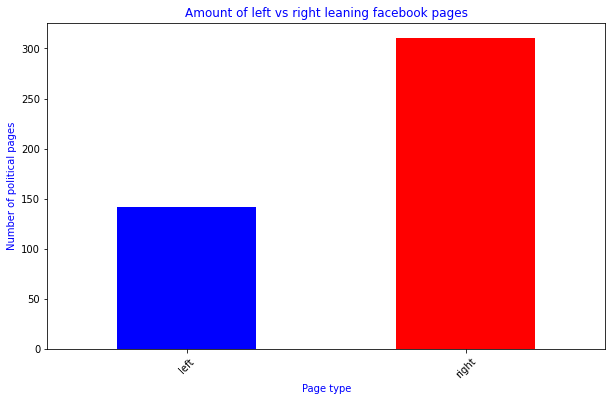

| political_category   |   page_id |
|:---------------------|----------:|
| left                 |       142 |
| right                |       310 |


In [12]:
group  = page_cat.groupby(["political_category"])["page_id"].count()
title = "Amount of left vs right leaning facebook pages"
ylabel = "Number of political pages"
xlabel = "Page type"
pltstatus(group,"bar",title,ylabel,xlabel)
print(group.to_markdown())

There are more right leaning facebook groups in this dataset

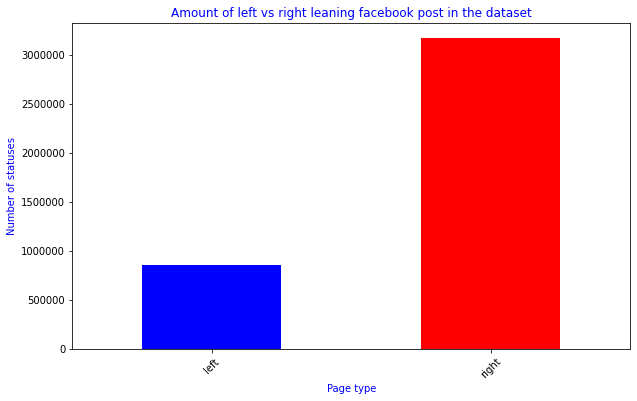

| political_category   |        status_id |
|:---------------------|-----------------:|
| left                 | 858236           |
| right                |      3.16469e+06 |


In [13]:
group  = statuses.groupby(["political_category"])["status_id"].count()
title = "Amount of left vs right leaning facebook post in the dataset"
ylabel = "Number of statuses"
xlabel = "Page type"
pltstatus(group,"bar",title,ylabel,xlabel)
print(group.to_markdown())

There are also more right leaning statuses.

Plot above shows a Hevily imbalanced dataset.
This might cause accuracy paradox, where we can get misleading accuracy due to class distribution.

One solution might be to under-sample the dataset.

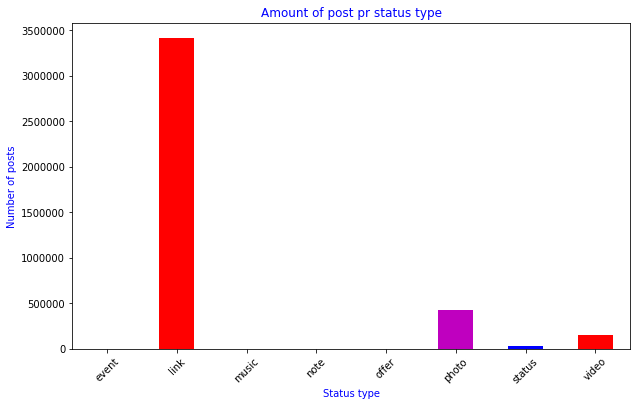

| status_type   |      status_type |
|:--------------|-----------------:|
| event         |   1231           |
| link          |      3.41357e+06 |
| music         |     93           |
| note          |     41           |
| offer         |     16           |
| photo         | 427401           |
| status        |  28433           |
| video         | 152139           |


In [14]:
group = statuses.groupby(["status_type"])["status_type"]
title = "Amount of post pr status type"
ylabel = "Number of posts"
xlabel = "Status type"
pltstatus(group.count(),"bar",title,ylabel,xlabel)
print(group.size().to_markdown())

Most of the status type are link, other types may also yeld viable information for classification

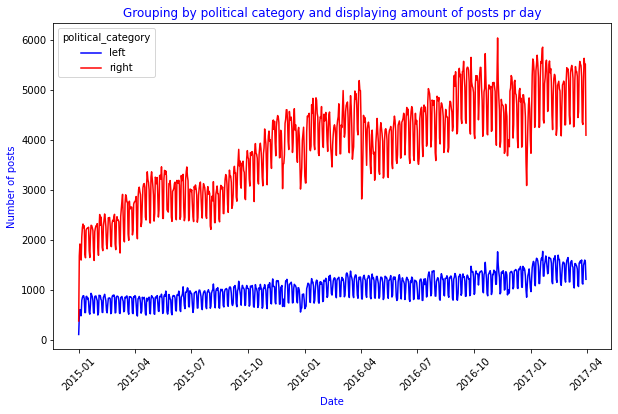

In [15]:
col = "status_id"
group = (statuses[(statuses[col] != 0)].groupby(["status_published","political_category"])[col].count()).reset_index()
group = group.pivot(index="status_published", columns="political_category", values=col)
title = f"Grouping by political category and displaying amount of posts pr day"
ylabel = f"Number of posts"
xlabel = "Date"
pltstatus(group,"line",title,ylabel,xlabel)

The graph above shows the amount of posts pr day from the belonging to the two parties

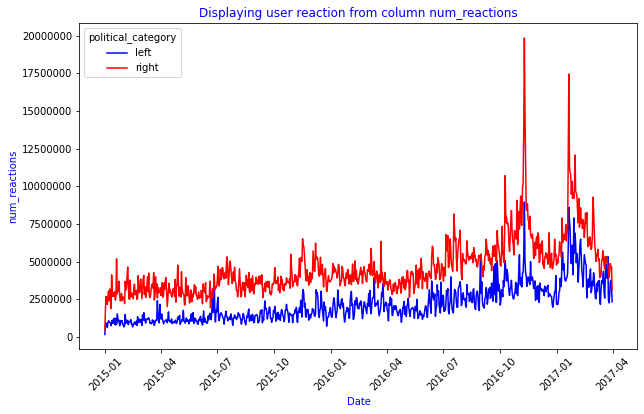

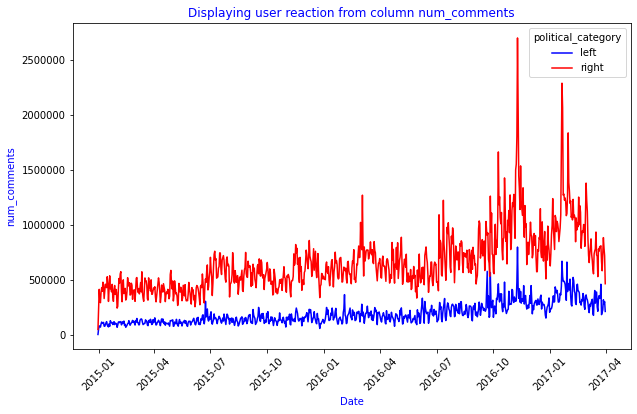

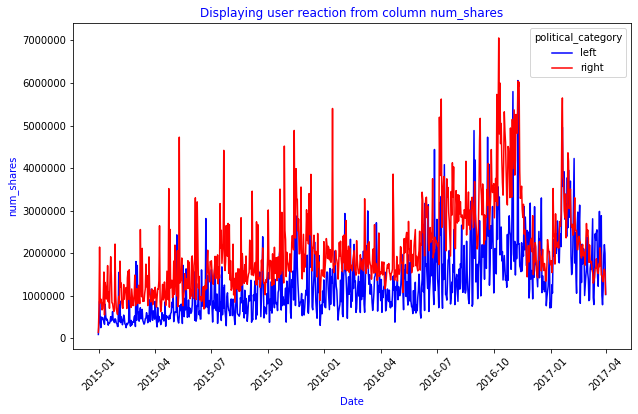

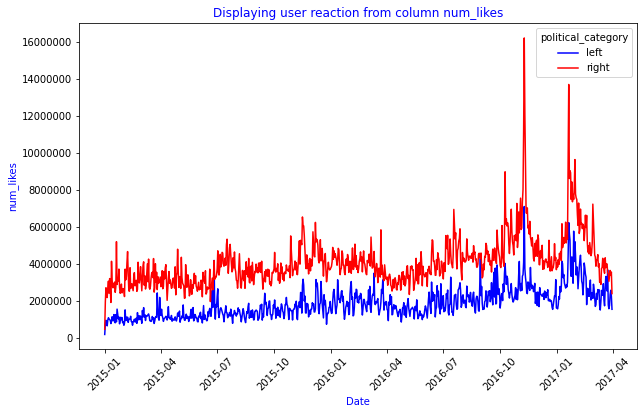

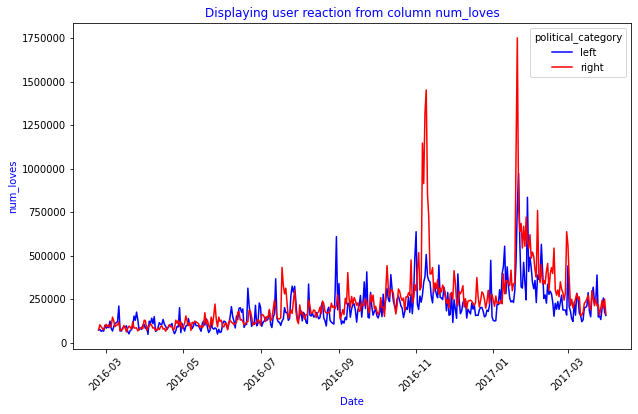

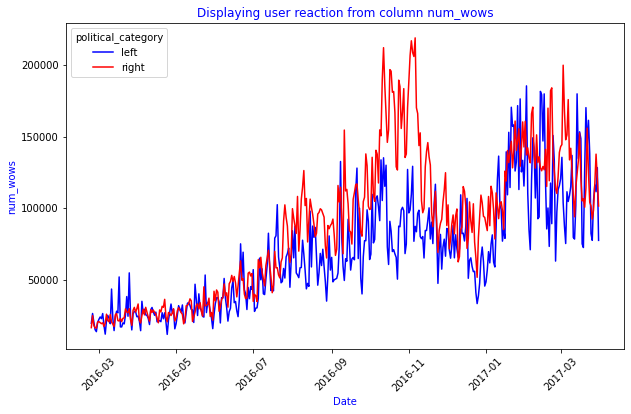

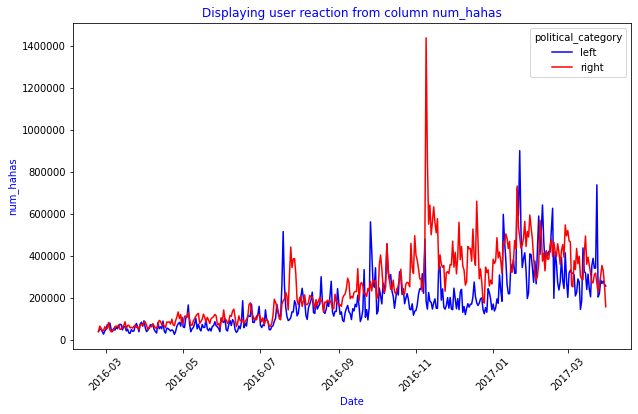

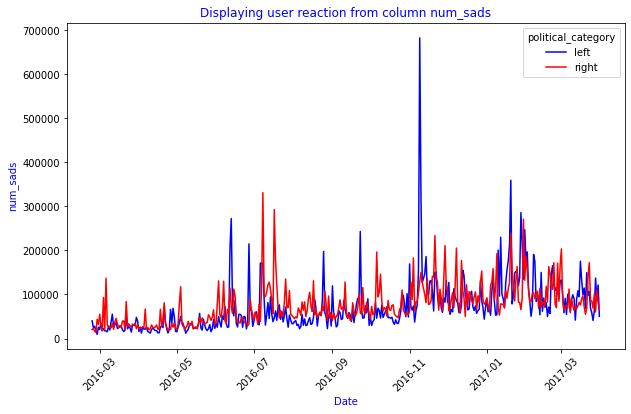

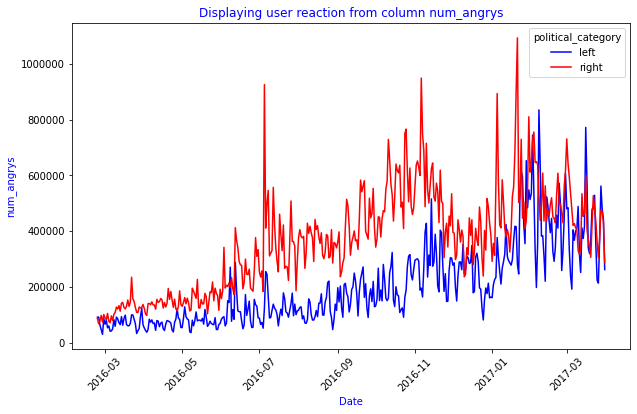

In [16]:
columns = statuses.columns[-9:]
#columns = ["num_likes","num_loves","num_sads","num_angrys"]

for col in columns:
    group = (statuses[(statuses[col] != 0)].groupby(["status_published","political_category"])[col].sum()).reset_index()
    group = group.pivot(index="status_published", columns="political_category", values=col)
    title = f"Displaying user reaction from column {col}"
    ylabel = f"{col}"
    xlabel = "Date"
    pltstatus(group,"line",title,ylabel,xlabel)

The plots above shows user interaction in the form of emojies, likes, etc.
A date that sticks out is 2016-11, when Trump won the American election.
We can see that num_sads has a large spike for the left, while num_hahas has a spike for the right.

#### Analyzing status_message column

Here we will focus on a single column

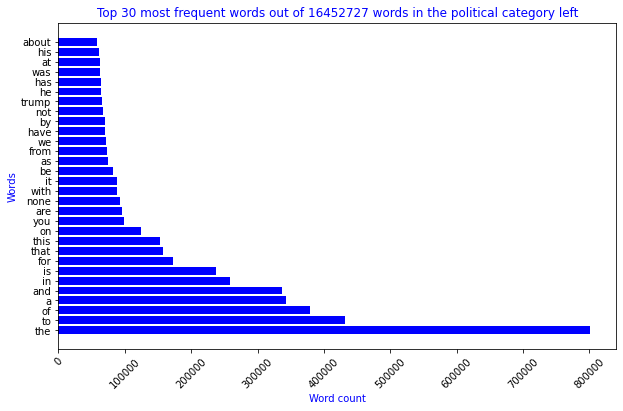

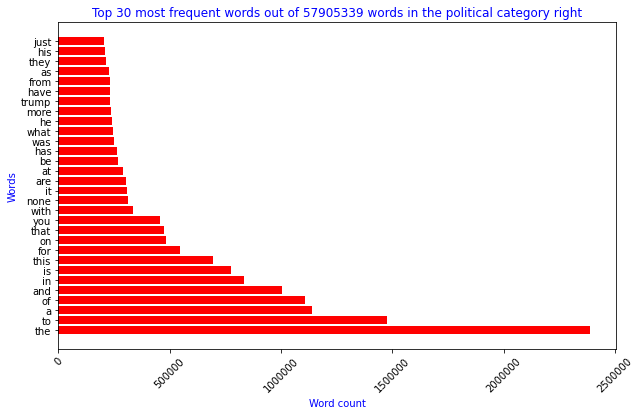

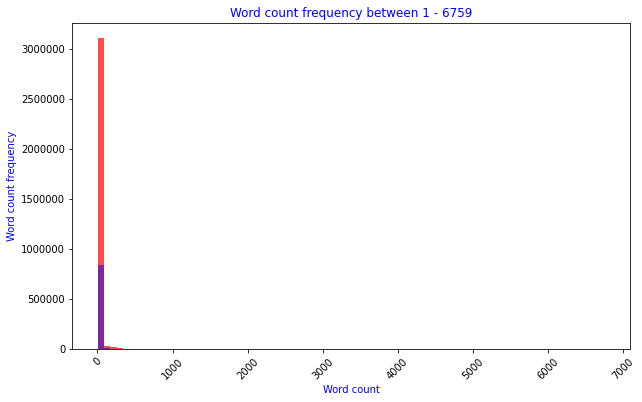

max: 6759
min: 1
mean: 18.483587062544558
median: 12.0
std: 38.4549008267351
Total word count:74358066


In [17]:
col = "status_message"
pltwordcount(statuses,col)

The data has a lot of noise, which is expected when working with text, so we have to remove stopwords.
There is also some messages wich has almost 7000 words. These satuses has to be filtered out.

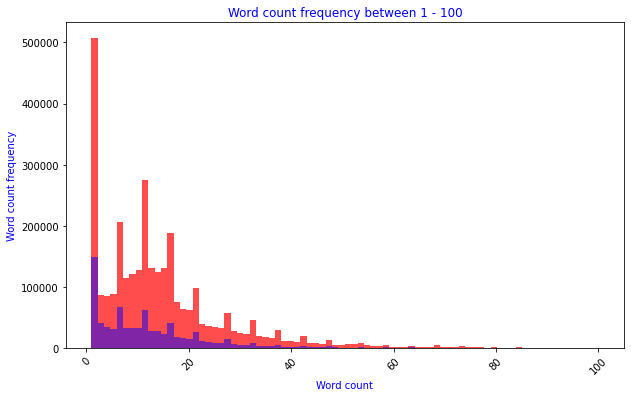

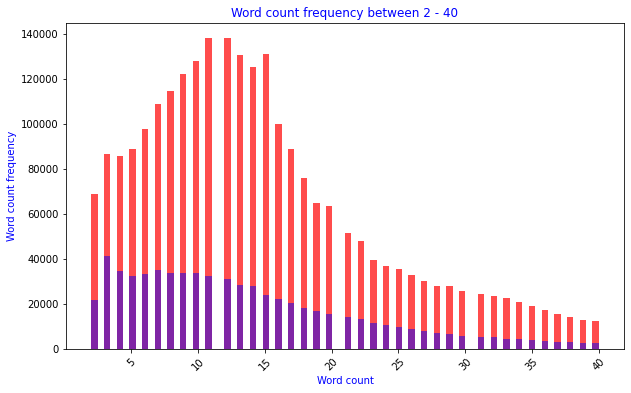

In [18]:
# There are status_messages with thousands of words
# zooming in for a closer look
ylabel = "Word count frequency"
xlabel = "Word count"

max = 100
histo =  statuses[col].str.lower().str.split().apply(len)
histo = histo[histo<=max]
title = f"Word count frequency between {histo.min()} - {histo.max()}"
pltstatus([histo[statuses["political_category"]=="left"],histo[statuses["political_category"]=="right"]],"hist",title,ylabel,xlabel)

#The word count for most is less than 40 words
#It would make sense to select messages with lower word count if this column will be used for classification

min = 2
max = 40
histo = histo[((histo>=min)&(histo<=max))]
title = f"Word count frequency between {histo.min()} - {histo.max()}"
pltstatus([histo[statuses["political_category"]=="left"],histo[statuses["political_category"]=="right"]],"hist",title,ylabel,xlabel)
#We can try values around 2-20

The graphs above shows that most messages have between 1 and 20 words.

In [19]:
print(statuses[statuses["political_category"] == "right"][[col,"status_type"]].value_counts()[:20].to_markdown())
#top 20 status_message for right leaning statuses

|                                                                                                                                                |      0 |
|:-----------------------------------------------------------------------------------------------------------------------------------------------|-------:|
| ('None', 'link')                                                                                                                               | 213950 |
| ('None', 'photo')                                                                                                                              |  85608 |
| ('★★★ Patriots Who Dare... Join our fight to save America! ➠ Click Here http://bb4sp.com/ #BB4SP', 'photo')                                    |  15670 |
| ('None', 'video')                                                                                                                              |  11754 |
| ('Americas Freedom Fighters', 'photo')                        

The text above indicates that the data cleaning has to include removal of web url's, emojies, "None" and other symbols

#### Analyzing link_name column
Here we will focus on a single column

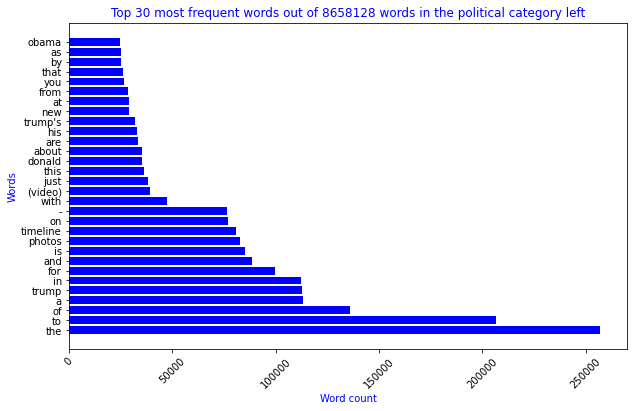

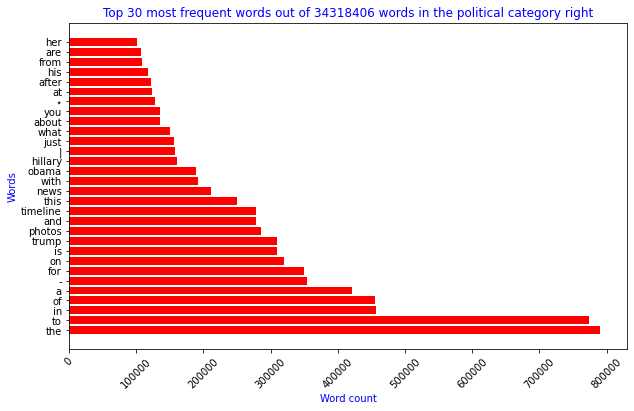

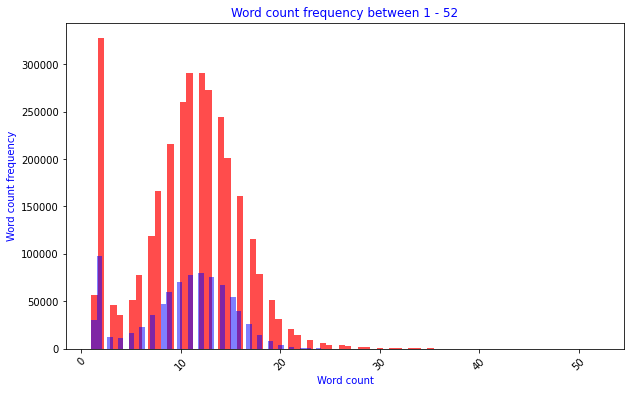

max: 52
min: 1
mean: 10.68290974425567
median: 11.0
std: 5.050388226576714
Total word count:42976534


In [20]:
col = "link_name"
pltwordcount(statuses,col)

The column link_name has generally fewer words per status compared to the status_message column

In [21]:
statuses.groupby(["political_category"])[col].value_counts().nlargest(20)
#top 20 link count grouped by category
#Timeline Photos and "None" has to be removed

political_category  link_name                  
right               Timeline Photos                277223
left                Timeline Photos                 80799
right               None                            40256
left                None                            19961
right               Nation In Distress               4910
                    RedFlag News                     4682
                    Mobile Uploads                   2761
                    Alex Jones                       2197
                    The Blacksphere                  2109
                    Dc Gazette                       1924
left                Mobile Uploads                   1688
right               Fox News                         1651
                    RedNeckish                       1637
left                Groopspeak                       1557
right               Donald J. Trump                  1456
                    Unofficial: President Trump      1416
                    Denn

## Data Cleaning

We select two columns to clean, link_name and status_message. 

In [22]:
def undersample(df):
  """
  Function to under-sample, due to imbalanced dataset
  """
  right_indices = df[df["political_category"] == "right"].index
  left_sample_size = len(df[df["political_category"] == "left"])
  random_indices = np.random.choice(right_indices, left_sample_size, replace=False)
  df = df.loc[random_indices].append(df[df["political_category"] == "left"])
  return df

In [23]:
def data_cleanup(df,fromdate,todate):
    """
        Removing duplicate statuses
        Statuses without both status_message and link_name will be removed
        Facebook's API counts changes to a pages cover photo as post, these posts will be removed
        Statuses between "fromdate" - "todate" will be used
    """
    dflen = len(df)

    df = df.drop_duplicates(subset=['status_id'])
    dflentemp = len(df)
    print(f"Removed {dflen-dflentemp} duplicate statuses")  

    df = df[~((df.link_name == "None") & (df.status_message == "None"))]
    print(f"Removed {dflentemp - len(df)} statuses where both status_message and link_name is not present") 
    dflentemp = len(df)

    photos = df.status_id[(df.status_type == "photo") & df.status_link.str.contains(r"^https://www.facebook.com") & df.link_name.str.contains(r"cover photo$")]
    df = df[~df["status_id"].isin(set(photos))]
    print(f"Removed {dflentemp-len(df)} where status was that a cover photo was changed") 
    dflentemp = len(df)

    df = df[(df["status_published"] >= pd.to_datetime(fromdate).date()) & (df["status_published"] <= pd.to_datetime(todate).date())]
    print(f"Removed {dflentemp-len(df)} by only selecting posts between {fromdate} - {todate}") 

    print(f"\nRemoved {dflen-len(df)} rows in total")
    return df

In [24]:
statuses = data_cleanup(statuses,"2015-01-01","2017-04-01")

Removed 257 duplicate statuses
Removed 676 statuses where both status_message and link_name is not present
Removed 1917 where status was that a cover photo was changed
Removed 495 by only selecting posts between 2015-01-01 - 2017-04-01

Removed 3345 rows in total


First we remove rows from the whole dataset based on different conditions, like duplicated rows and if link_name and status_message has a value "None"

The function belove takes a column name as a input, therafter the function will remove duplicates, "None", stopwords, numbers, url and special characters, set text to lower, undersampling because the data was imbalanced, and finally stemming

In [25]:
def textedit(df,col,min=7,max=17):   
    """
        Removes duplicates, "None", stopwords, numbers, url and special characters, sets text to lower, undersampling and stemming
    """
    start = datetime.now()
    dflen = len(df)
    df = df.drop_duplicates(subset=[col]) #Removing duplicates
    df = df[~(df[col] == "None")] 

    df[col] = df[col].str.lower().replace(r"\n|\r|https?\:\/\/\S+|www\.\S+|[\w]*\.(com|edu|net|org)([^\w\/]|\/+\S*)*|[^a-z\s\']|((?:^|\B)(\')|(\')(?:\s|$))"," ", regex = True).astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))#.str.split()
    df[col] = df[col].str.lower().replace(r"(.)\1{3,}", r"\1", regex = True)
    df = df[df[col].str.strip() !='']
    df[col] = df[col].str.split()
    #removes url's, /r and \n --> \n|\r|https?\:\/\/\S+|www\.\S+|[\w]*\.(com|edu|net|org)([^\w\/]|\/+\S*)*
    #remove repeating characters n>3  --> (.)\1{3,}
    #removes characters not in the range: a-z, whitespace and '  -->  [^a-z\s\']
    #example: 2"3can't"/ becomes can't
    #removes single quotes not within a word  -->  ((?:^|\B)(\')|(\')(?:\s))
    #example: '''shouldn't '''''' becomes shouldn't
    
    wordcount = df[col].apply(len)
    df = df[((wordcount >= (min)) & (wordcount <= (max)))][["political_category",col]] #removing statuses where the word count is less than min value and more than max value
    print(f"Removed {dflen - len(df)} \"None\" values or low word count in the column {col}: {datetime.now() - start}")
    dflentemp = len(df)

    df = undersample(df)

    estopwords = stopwords.words("english")
    stemmer = SnowballStemmer("english")
    stopwatch = datetime.now()
    
    ## Stemming takes longer time but may give better result
    df[col] = df[col].apply(lambda x:" ".join([stemmer.stem(word) for word in x if word not in estopwords and len(word)>2])) #stemming and removing stopwords
    #df[col] = df[col].apply(lambda x:" ".join([word for word in x if word not in estopwords and len(word)>2])) #removing stopwords    
    df = df[(df[col].astype(bool))] #Removing empty due to stopwords
    print(f"stopwords and stemming: {datetime.now() - stopwatch}")
    print(f"Total time: {datetime.now() - start}")
    print("\nUndersampled dataset:")
    print(df.groupby("political_category").count().to_markdown()+"\n"*2)
    df["target"] = np.where(df["political_category"] == "left", 0, 1)
    pltwordcount(df,col)
    return df

In [26]:
def textedit_link(df,col,min=7,max=17):   
    """
        Removes duplicates, "None", stopwords, numbers, url and special characters, sets text to lower, undersampling and stemming
    """
    start = datetime.now()
    dflen = len(df)
    df = df.drop_duplicates(subset=[col]) #Removing duplicates
    df = df[~(df[col] == "None")] 

    df = df[~(df.link_name == "Timeline Photos")]
    print(f"Removed {dflen - len(df)} statuses where link name was 'Timeline Photos' none values and duplicates") 
    dflentemp = len(df)

    df[col] = df[col].str.lower().replace(r"\n|\r|https?\:\/\/\S+|www\.\S+|[\w]*\.(com|edu|net|org)([^\w\/]|\/+\S*)*|[^a-z\s\']|((?:^|\B)(\')|(\')(?:\s|$))"," ", regex = True).astype(str).apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))#.str.split()
    df[col] = df[col].str.lower().replace(r"(.)\1{3,}", r"\1", regex = True)
    df = df[df[col].str.strip() !='']
    df[col] = df[col].str.split()
    #removes url's, /r and \n --> \n|\r|https?\:\/\/\S+|www\.\S+|[\w]*\.(com|edu|net|org)([^\w\/]|\/+\S*)*
    #remove repeating characters n>3  --> (.)\1{3,}
    #removes characters not in the range: a-z, whitespace and '  -->  [^a-z\s\']
    #example: 2"3can't"/ becomes can't
    #removes single quotes not within a word  -->  ((?:^|\B)(\')|(\')(?:\s))
    #example: '''shouldn't '''''' becomes shouldn't
    
    wordcount = df[col].apply(len)
    df = df[((wordcount >= (min)) & (wordcount <= (max)))][["political_category",col]] #removing statuses where the word count is less than min value and more than max value
    print(f"Removed {dflentemp - len(df)} \"None\" values or low word count in the column {col}: {datetime.now() - start}")
    dflentemp = len(df)

    df = undersample(df)

    estopwords = stopwords.words("english")
    stemmer = SnowballStemmer("english")
    stopwatch = datetime.now()
    
    ## Stemming takes longer time but may give better result
    df[col] = df[col].apply(lambda x:" ".join([stemmer.stem(word) for word in x if word not in estopwords and len(word)>2])) #stemming and removing stopwords
    #df[col] = df[col].apply(lambda x:" ".join([word for word in x if word not in estopwords and len(word)>2])) #removing stopwords    
    df = df[(df[col].astype(bool))] #Removing empty due to stopwords
    print(f"stopwords and stemming: {datetime.now() - stopwatch}")
    print(f"Total time: {datetime.now() - start}")
    print("\nUndersampled dataset:")
    print(df.groupby("political_category").count().to_markdown()+"\n"*2)
    df["target"] = np.where(df["political_category"] == "left", 0, 1)
    pltwordcount(df,col)
    return df

Removed 1709129 "None" values or low word count in the column status_message: 0:01:55.592254
stopwords and stemming: 0:03:37.243370
Total time: 0:05:34.194310

Undersampled dataset:
| political_category   |   status_message |
|:---------------------|-----------------:|
| left                 |           595916 |
| right                |           595963 |




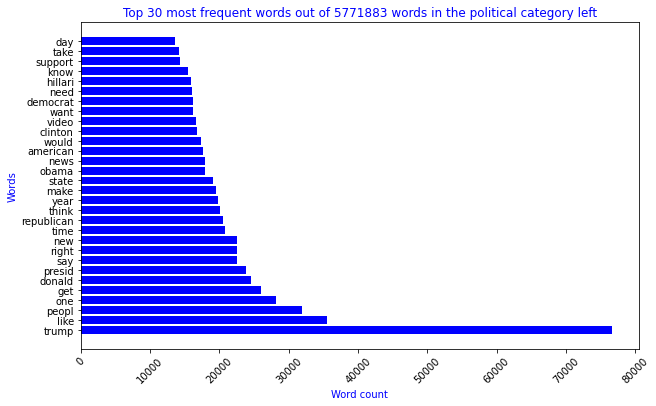

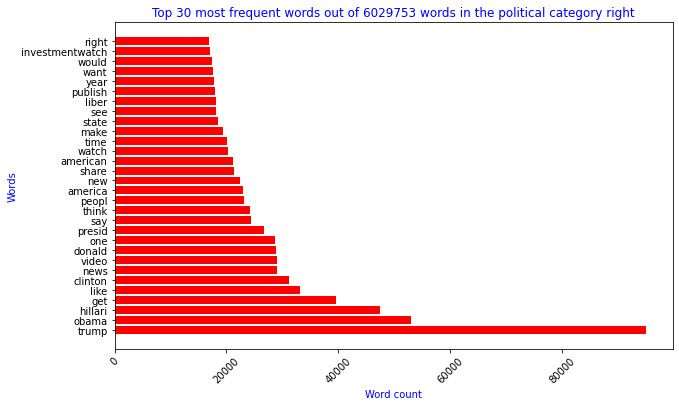

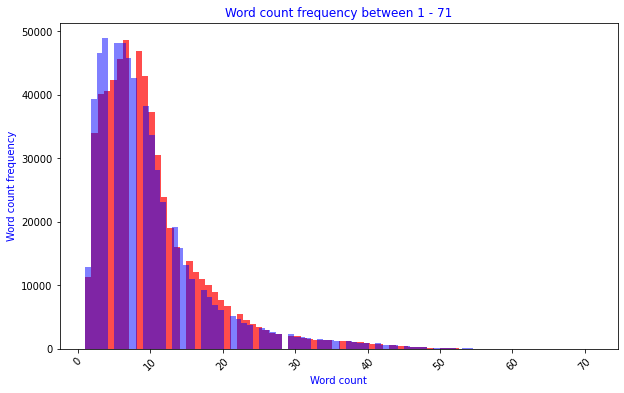

max: 71
min: 1
mean: 9.901706465169703
median: 8.0
std: 7.610000147919599
Total word count:11801636


In [27]:
col = "status_message"
#df_message = textedit(statuses,col,min=2,max=20)
df_message = textedit(statuses,col,min=2,max=80)

After removing stopwords and statuses with high word count, the most frequent word for both paries are "Trump".
The word count is now almost equal for the two paries

Removed 1856526 statuses where link name was 'Timeline Photos'
Removed 871 "None" values or low word count in the column link_name: 0:01:09.634948
stopwords and stemming: 0:02:37.245334
Total time: 0:03:48.124315

Undersampled dataset:
| political_category   |   link_name |
|:---------------------|------------:|
| left                 |      576676 |
| right                |      576647 |




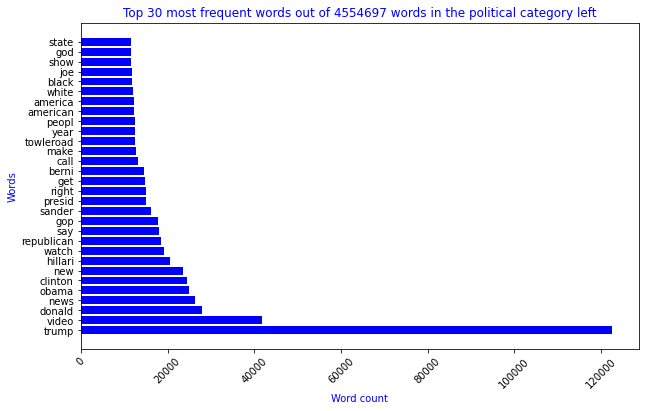

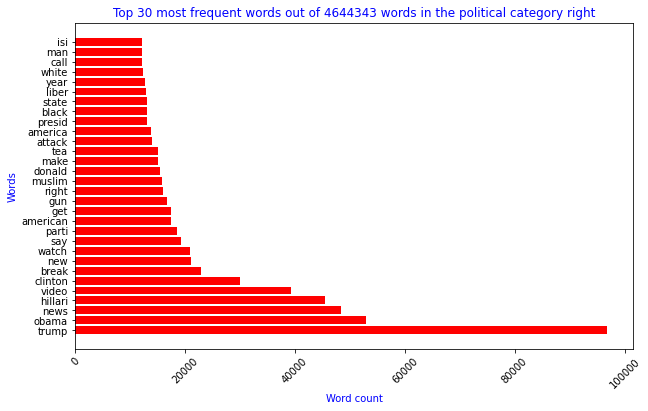

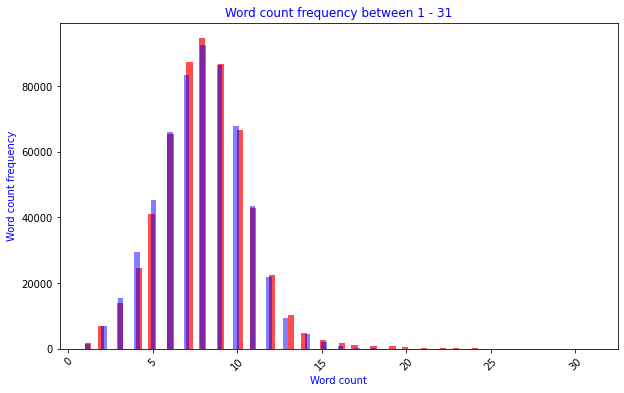

max: 31
min: 1
mean: 7.976117705100826
median: 8.0
std: 2.5782873192860887
Total word count:9199040


In [28]:
col = "link_name"
#df_link = textedit(statuses,col,min=7,max=17)
df_link = textedit_link(statuses,col,min=1,max=52)

The same result shows for the column link_name as well.

Combining link and message in the same column below

In [29]:
#Creating database with combined link name and status message column

df1 = df_link
df2 = df_message

df2.rename(columns={'political_category':'polit_cat'}, inplace=True)
df2.rename(columns={'target':'target1'}, inplace=True)

df_link_message = pd.concat([df1, df2], axis=1, join="outer")
df_link_message["political_category"].update(df_link_message.pop("polit_cat"))
df_link_message["target"].update(df_link_message.pop("target1"))

df_link_message["link and message"] = df_link_message["link_name"].fillna(' ') + ' ' + df_link_message["status_message"].fillna(' ')
df_link_message["link and message"] = df_link_message["link and message"].str.strip()
df_link_message = df_link_message[["political_category", "link and message", "target"]]

df_link_message = undersample(df_link_message)

df2.rename(columns={'polit_cat':'political_category'}, inplace=True)
df2.rename(columns={'target1':'target'}, inplace=True)

In [81]:
print(df_link_message.groupby("political_category").count().to_markdown()+"\n"*2)

| political_category   |   link and message |   target |
|:---------------------|-------------------:|---------:|
| left                 |             732189 |   732189 |
| right                |             732189 |   732189 |




The cell below frees up ram by unloading the statuses from memory

In [30]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

print("Removing original dataframe statuses")
##If you have memory issues uncomment this before continiuing
##Or use google colab
del statuses
gc.collect()

                      statuses:  3.7 GiB
                             _: 299.5 MiB
                           _21: 299.5 MiB
               df_link_message: 295.0 MiB
                    df_message: 250.5 MiB
                           df2: 250.5 MiB
                       df_link: 229.9 MiB
                           df1: 229.9 MiB
                         histo: 48.2 MiB
                    pages_info: 244.4 KiB
Removing original dataframe statuses


14993

## Classification
Text classification with classical machine learning

In [31]:
def benchmark(clf,train_x_,train_y_,test_x_,test_y_):
  """
  Function to train, fit and predict
  Returns dictionary with classifier information
  """
  results = {}
  for clf, name in (clf):
    print('=' * 80)
    print(name)
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(train_x_, train_y_)
    train_time = str(time() - t0)
    print(f"train time: {train_time}" )
    t0 = time()
    pred = clf.predict(test_x_)
    test_time = str(time() - t0)
    print(f"test time:  {test_time}")
    score = accuracy_score(test_y_, pred)
    print("accuracy:   %0.3f" % score)
    print("classification report:")
    tnames = ["left","right"]
    print(classification_report(test_y_, pred, target_names=tnames))
    df_conf_matrix = pd.DataFrame(confusion_matrix(test_y_, pred), index=tnames, columns=tnames)
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels())
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title(f"Confusion Matrix for {name}\nTest data")
    plt.show()
    print()
    clf_descr = str(clf).split('(')[0]

    results.update({name:[clf.get_params(), score, train_time, test_time,clf_descr]})
  return results
  
def plt_clf(results,title="Score"):
  """
  Function for plotting the score and time of classifiers
  """
  indices = np.arange(len(results))
  name = [i for i in results]
  score = [j[1] for j in [results[i] for i in results]]
  training_time = [j[2] for j in [results[i] for i in results]]
  test_time = [j[3] for j in [results[i] for i in results]]
  training_time_ind = np.array(training_time).astype(np.float)
  test_time_ind = np.array(test_time).astype(np.float)
  training_time_ind = training_time_ind / np.max(training_time_ind)
  test_time_ind = test_time_ind / np.max(test_time_ind)
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.barh(indices, score, .2, label="Score", color='navy')
  plt.barh(indices + .3, training_time_ind, .2, label="Training time", color='c')
  plt.barh(indices + .6, test_time_ind, .2, label="Test time", color='darkorange')
  plt.yticks(())
  plt.legend(loc='best')
  plt.subplots_adjust(left=.25)
  plt.subplots_adjust(top=.95)
  plt.subplots_adjust(bottom=.05)
  for i in indices:
    plt.text(-.3, i,  f"{name[i]}\n"
                      f"Score: {np.round(score[i],8)}\n"
                      f"Training time: {np.round(float(training_time[i]),2)}\n"
                      f"Test time: {np.round(float(test_time[i]),2)}")
  plt.show()
  
def whitespace_tokenizer(s):
   return s.split()


def gridsearch(pipe,para,train_x_,train_y_, cv = 5, plot=True):
  """
  Function gridsearch as well as plotting the result
  """
  stopwatch = datetime.now()
  grid = GridSearchCV(pipe, para, n_jobs=-1, verbose=1, cv = cv, return_train_score=True)#, scoring="accuracy")
  #grid = RandomizedSearchCV(pipe, para, n_jobs=-1, verbose=1, cv = cv, return_train_score=True,random_state=101)#, scoring="accuracy")
  grid.fit(train_x_,train_y_)

  #metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
  grid_results={}
  para = []
  paraname= []
  for i,k in enumerate(list(zip(*grid.param_grid.items()))[1]):
    if len(k)>1:
      para.append(k)
      paraname.append((list(zip(*grid.param_grid.items()))[0][i]))
  #longest=max((len(l), i) for i, l in enumerate(para))[1]
  secondlongest = 0
  if len(para) >1:
    secondlongest = [len(i) for i in para]
    secondlongest.remove(sorted(secondlongest)[-1])
    secondlongest = np.argmax(secondlongest)
  
  for i,dic in enumerate(grid.cv_results_["params"]):
    score = grid.cv_results_["mean_test_score"][i]
    train_time = grid.cv_results_["mean_fit_time"][i]
    test_time = grid.cv_results_["mean_score_time"][i]
    title ,name= "",""
    for k,v in dic.items():
      if k in paraname:
        ksplit = k.split(grid.estimator.steps[-1][0]+"__")[-1]+" :"+str(v)+" "
        if len(para) >1 and  sum((len(l)) for l in para) >4:
          if k == paraname[secondlongest]:
            title=f"Result grouped by {ksplit}"
            continue
        else:
          title="Result"
        name += ksplit
    if title not in grid_results:
        grid_results.update({title:[[name, score, train_time, test_time,name]]})
    else:
      grid_results[title].append([name, score, train_time, test_time,name])
  if plot:
    for i in grid_results:
      p={}
      for j,k in enumerate(grid_results[i]):
        p.update({k[0]:k})
      print("_"*100)
      plt_clf(p,f"{i}")
      print("_"*100)         
  print("Best score: {:.2f}".format(grid.best_score_))
  print("Best parameters: ", grid.best_params_)
  print(f"Time: {datetime.now() - stopwatch}")
  #return grid
  return (grid.best_estimator_[-1].get_params())

## Using column link_name for classification

In [32]:
df = df_link
col = "link_name"

In [33]:
#splitting the data to do gridsearch and cross validation with only train split. Then testing the best parameters on the test set.

################################ 0,3 to 0,6
train_x, test_x, train_y, test_y = train_test_split(df[col],df["target"], test_size=0.3, random_state=101, shuffle=True,stratify=df["target"])

##Splitting into training + test (80%) and validation (20%)
#train_val_x, val_x, train_val_y, val_y = train_test_split(df[col],df["target"], test_size=0.2, random_state=101, shuffle=True,stratify=df["target"])
##Splitting training+test ito training(60%) and test(20%)
#train_x, test_x, train_y, test_y = train_test_split(train_val_x,train_val_y, test_size=0.25, random_state=101,stratify=y_train_val)

In [34]:
stopwatch = datetime.now()

vectorizer = TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)#, binary=True)
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

total_features = train_x_vectors.shape[1]
max_features = 100000
selector = SelectKBest(chi2, k = max_features)
train_x_vectors = selector.fit_transform(train_x_vectors, train_y)
test_x_vectors = selector.transform(test_x_vectors)

#feature_names = vectorizer.get_feature_names()
#feature_names = np.asarray([feature_names[i] for i in selector.get_support(indices=True)])

print(f"fit & transform, selecting top the {max_features} of {total_features} features")
print(f"Time: {datetime.now() - stopwatch}")

fit & transform, selecting top the 100000 of 2033089 features
Time: 0:00:34.537776


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(max_depth=50)
train time: 248.74350905418396
test time:  7.021212816238403
accuracy:   0.711
classification report:
              precision    recall  f1-score   support

        left       0.68      0.80      0.74    173003
       right       0.76      0.62      0.68    172994

    accuracy                           0.71    345997
   macro avg       0.72      0.71      0.71    345997
weighted avg       0.72      0.71      0.71    345997



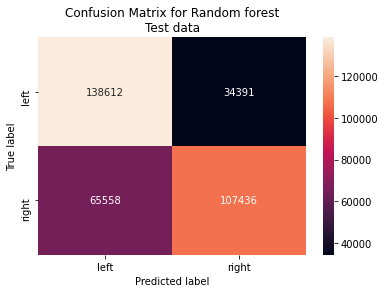


LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(max_iter=300, solver='saga')
train time: 14.21621584892273
test time:  0.014999151229858398
accuracy:   0.776
classification report:
              precision    recall  f1-score   support

        left       0.77      0.79      0.78    173003
       right       0.78      0.77      0.77    172994

    accuracy                           0.78    345997
   macro avg       0.78      0.78      0.78    345997
weighted avg       0.78      0.78      0.78    345997



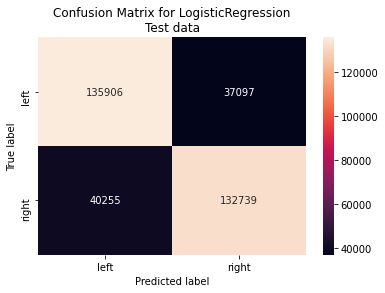


LinearSVC
________________________________________________________________________________
Training: 
LinearSVC()
train time: 14.187333822250366
test time:  0.020331382751464844
accuracy:   0.783
classification report:
              precision    recall  f1-score   support

        left       0.78      0.79      0.79    173003
       right       0.79      0.77      0.78    172994

    accuracy                           0.78    345997
   macro avg       0.78      0.78      0.78    345997
weighted avg       0.78      0.78      0.78    345997



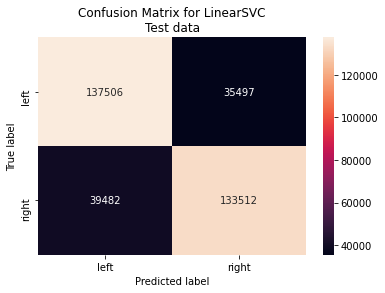


MultinomialNB
________________________________________________________________________________
Training: 
MultinomialNB()
train time: 0.16196799278259277
test time:  0.04136252403259277
accuracy:   0.771
classification report:
              precision    recall  f1-score   support

        left       0.77      0.78      0.77    173003
       right       0.78      0.76      0.77    172994

    accuracy                           0.77    345997
   macro avg       0.77      0.77      0.77    345997
weighted avg       0.77      0.77      0.77    345997



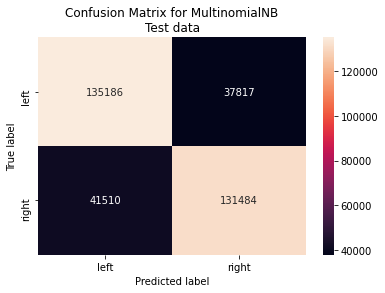


XGBClassifier
________________________________________________________________________________
Training: 
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
C:\Users\rzbe\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label

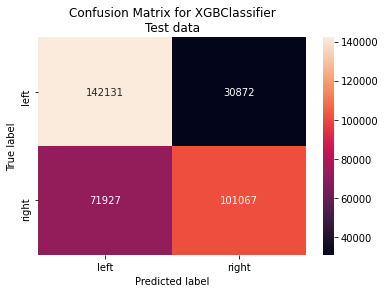


GradientBoostingClassifier
________________________________________________________________________________
Training: 
GradientBoostingClassifier()
train time: 546.6302125453949
test time:  0.3928825855255127
accuracy:   0.646
classification report:
              precision    recall  f1-score   support

        left       0.60      0.87      0.71    173003
       right       0.76      0.42      0.54    172994

    accuracy                           0.65    345997
   macro avg       0.68      0.65      0.63    345997
weighted avg       0.68      0.65      0.63    345997



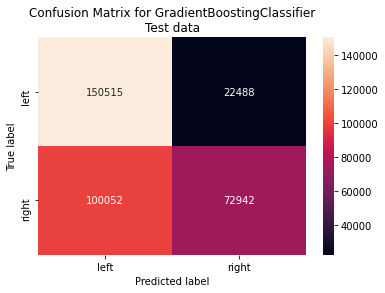


AdaBoostClassifier
________________________________________________________________________________
Training: 
AdaBoostClassifier()
train time: 131.4142415523529
test time:  3.305072069168091
accuracy:   0.634
classification report:
              precision    recall  f1-score   support

        left       0.59      0.88      0.71    173003
       right       0.76      0.39      0.52    172994

    accuracy                           0.63    345997
   macro avg       0.68      0.63      0.61    345997
weighted avg       0.68      0.63      0.61    345997



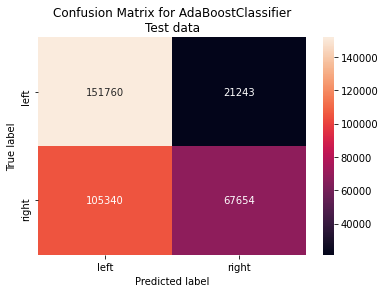


SGDClassifier
________________________________________________________________________________
Training: 
SGDClassifier()
train time: 1.8435087203979492
test time:  0.0149993896484375
accuracy:   0.721
classification report:
              precision    recall  f1-score   support

        left       0.69      0.79      0.74    173003
       right       0.76      0.65      0.70    172994

    accuracy                           0.72    345997
   macro avg       0.73      0.72      0.72    345997
weighted avg       0.73      0.72      0.72    345997



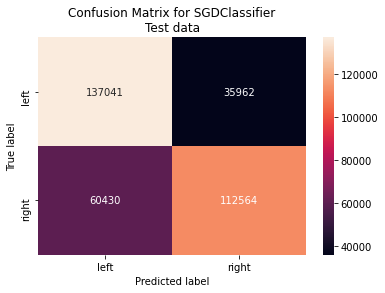

In [35]:
classifiers = [
           (SGDClassifier(), "SGDClassifier"),

           (AdaBoostClassifier(), "AdaBoostClassifier"),

           (GradientBoostingClassifier(), "GradientBoostingClassifier"),

           (XGBClassifier(), "XGBClassifier"),

           (MultinomialNB(), "MultinomialNB"),

           (LinearSVC(),"LinearSVC"),

           (LogisticRegression(max_iter=300,solver="saga"), "LogisticRegression"),

           (RandomForestClassifier(max_depth=50), "Random forest")
]
results = benchmark(classifiers[::-1],train_x_vectors, train_y, test_x_vectors, test_y)

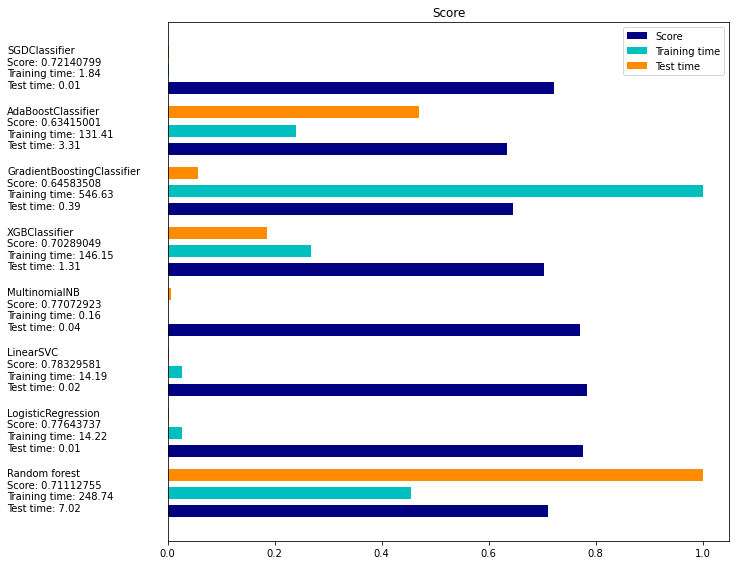

In [36]:
plt_clf(results)

## Parameter tuning with gridsearch

In [37]:
#Setting cross validation to 3
cv = 3
gridplot = True

### LinearSVC

Fitting 3 folds for each of 10 candidates, totalling 30 fits
____________________________________________________________________________________________________


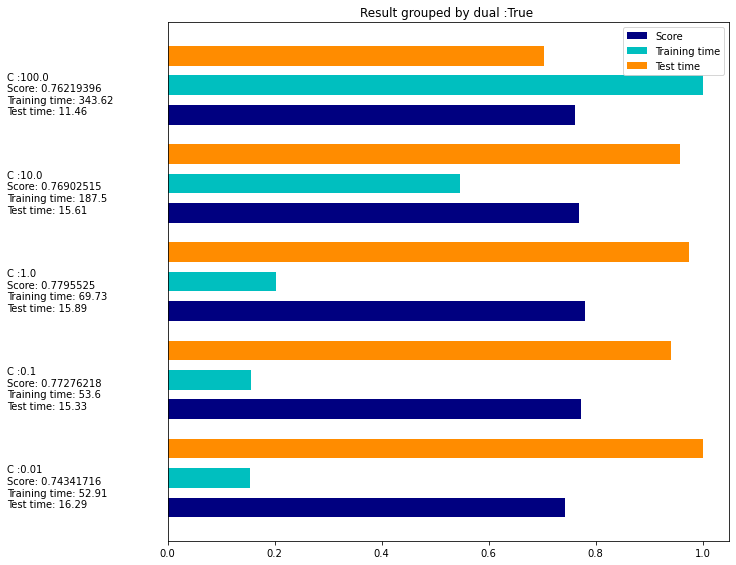

____________________________________________________________________________________________________
____________________________________________________________________________________________________


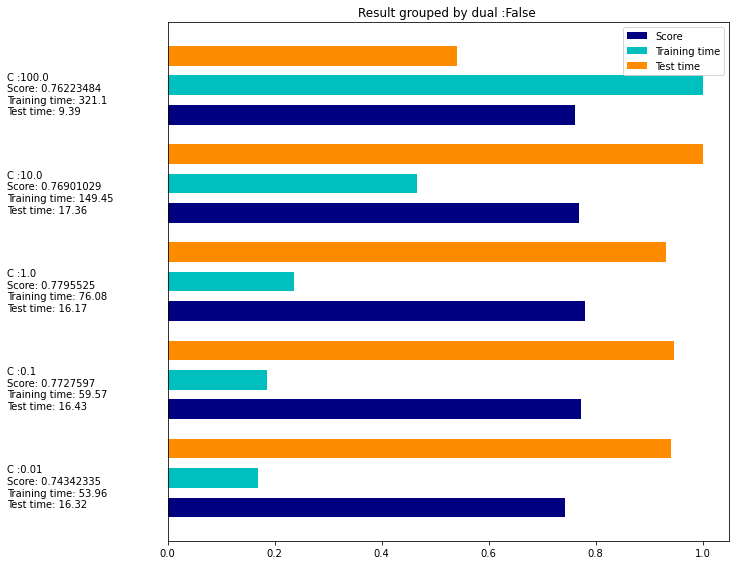

____________________________________________________________________________________________________
Best score: 0.78
Best parameters:  {'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'svc__C': 1.0, 'svc__dual': True, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Time: 0:14:03.944412


In [38]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("svc", LinearSVC())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "svc__dual": [True,False],
              "svc__C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}

LinearSVC_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### MultinomialNB

Fitting 3 folds for each of 3 candidates, totalling 9 fits
____________________________________________________________________________________________________


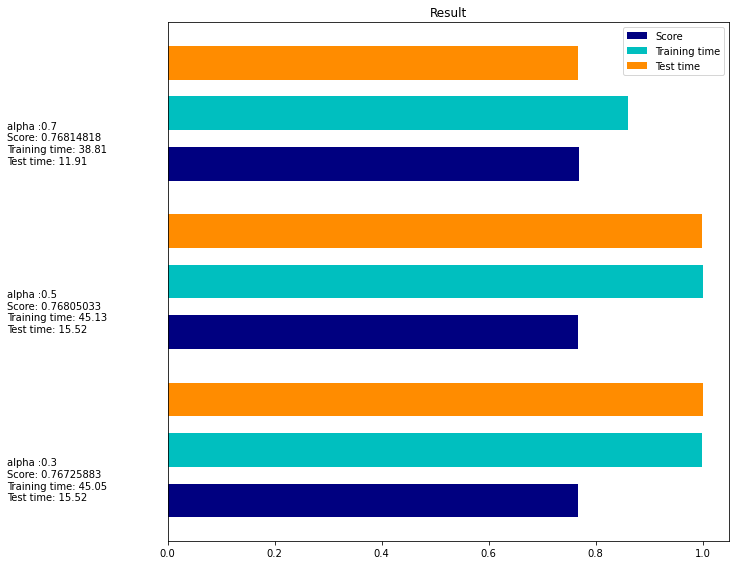

____________________________________________________________________________________________________
Best score: 0.77
Best parameters:  {'mnb__alpha': 0.7, 'mnb__fit_prior': True, 'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'tfidf__binary': True, 'tfidf__lowercase': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__tokenizer': <function whitespace_tokenizer at 0x000001F9A077AE50>, 'tfidf__use_idf': True}
Time: 0:02:37.377058


In [39]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("mnb", MultinomialNB())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__tokenizer": [whitespace_tokenizer],
              "tfidf__binary": [True],
              "tfidf__lowercase": [False],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "mnb__alpha": [0.3,0.5,0.7],
              "mnb__fit_prior": [True]}

MultinomialNB_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### Bernoulli bayes

Fitting 3 folds for each of 3 candidates, totalling 9 fits
____________________________________________________________________________________________________


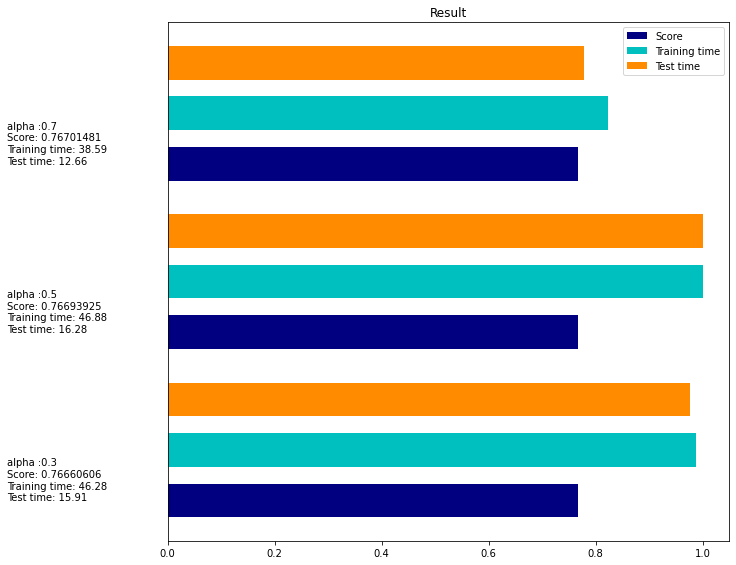

____________________________________________________________________________________________________
Best score: 0.77
Best parameters:  {'mnb__alpha': 0.7, 'mnb__fit_prior': True, 'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'tfidf__binary': True, 'tfidf__lowercase': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__tokenizer': <function whitespace_tokenizer at 0x000001F9A077AE50>, 'tfidf__use_idf': True}
Time: 0:02:41.858487


In [40]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("mnb", BernoulliNB())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__tokenizer": [whitespace_tokenizer],
              "tfidf__binary": [True],
              "tfidf__lowercase": [False],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "mnb__alpha": [0.3,0.5,0.7],
              "mnb__fit_prior": [True]}

BernoulliNB_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### LogisticRegression

Fitting 3 folds for each of 5 candidates, totalling 15 fits
____________________________________________________________________________________________________


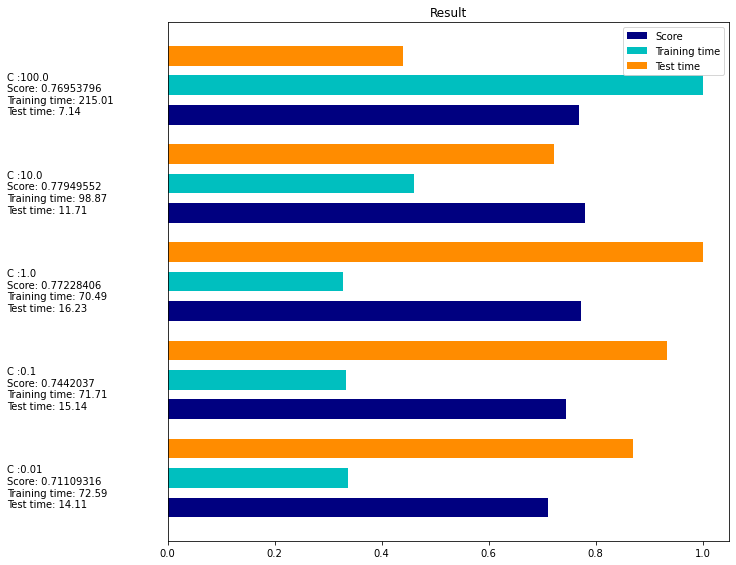

____________________________________________________________________________________________________
Best score: 0.78
Best parameters:  {'lr__C': 10.0, 'lr__max_iter': 300, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Time: 0:07:10.298388


In [41]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("lr", LogisticRegression())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "lr__solver": ["saga"],
              "lr__penalty": ["l2"],
              "lr__C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
              "lr__max_iter":[300]}

LogisticRegression_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv,plot=gridplot)

### Results

LogisticRegression_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F9A077AE50>)),
                ('select',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x000001F85D8D3940>)),
                ('lr',
                 LogisticRegression(C=10.0, max_iter=300, solver='saga'))])
train time: 60.94969916343689
test time:  7.31506085395813
accuracy:   0.783
classification report:
              precision    recall  f1-score   support

        left       0.78      0.79      0.79    173003
       right       0.79      0.77      0.78    172994

    accuracy                           0.78    345997
   macro avg       0.78      0.78      0.78    345997
weighted avg      

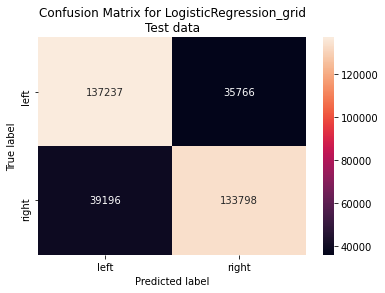


LinearSVC_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F9A077AE50>)),
                ('select',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x000001F85D8D3940>)),
                ('svc', LinearSVC())])
train time: 41.756784439086914
test time:  7.3195178508758545
accuracy:   0.783
classification report:
              precision    recall  f1-score   support

        left       0.78      0.79      0.79    173003
       right       0.79      0.77      0.78    172994

    accuracy                           0.78    345997
   macro avg       0.78      0.78      0.78    345997
weighted avg       0.78      0.78      0.78    345997



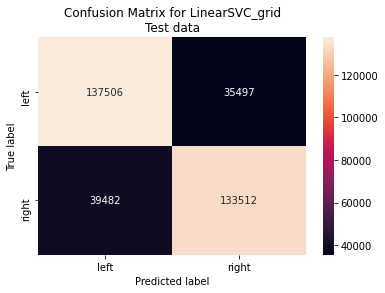


MultinomialNB_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F9A077AE50>,
                                 use_idf=False)),
                ('select',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x000001F85D8D3940>)),
                ('mnb', MultinomialNB(alpha=0.7))])
train time: 22.943678617477417
test time:  6.04014778137207
accuracy:   0.769
classification report:
              precision    recall  f1-score   support

        left       0.76      0.78      0.77    173003
       right       0.77      0.76      0.77    172994

    accuracy                           0.77    345997
   macro avg       0.77      0.77      0.77    345997
weighte

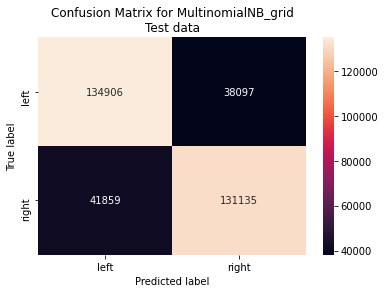

In [42]:
classifiers_grid = [
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True,use_idf=False,binary=True)),
                  ("select", SelectKBest(chi2, k = 100000)),
                  ("mnb", MultinomialNB(**MultinomialNB_grid))
                  ])),"MultinomialNB_grid"),
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)),
                  ("select", SelectKBest(chi2, k = 100000)),
                  ("svc", LinearSVC(**LinearSVC_grid))
                  ])),"LinearSVC_grid"),
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)),
                  ("select", SelectKBest(chi2, k = 100000)),
                  ("lr", LogisticRegression(**LogisticRegression_grid))
                  ])),"LogisticRegression_grid")
               ]
results_grid = benchmark(classifiers_grid[::-1],train_x, train_y, test_x, test_y)

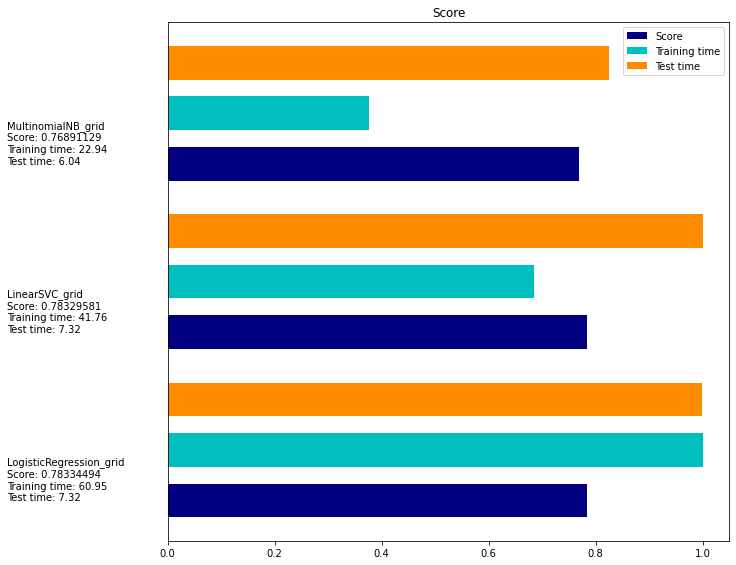

In [43]:
plt_clf(results_grid)

## Using column status_message for classification

In [59]:
col = "status_message"
df = df_message

In [60]:
#splitting the data to do gridsearch and cross validation with only train split. Then testing the best parameters on the test set.
train_x, test_x, train_y, test_y = train_test_split(df[col],df["target"], test_size=0.3, random_state=101, shuffle=True,stratify=df["target"])


In [61]:
stopwatch = datetime.now()

vectorizer = TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)#, binary=True)
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

total_features = train_x_vectors.shape[1]
max_features = 100000
selector = SelectKBest(chi2, k = max_features)
train_x_vectors = selector.fit_transform(train_x_vectors, train_y)
test_x_vectors = selector.transform(test_x_vectors)

#feature_names = vectorizer.get_feature_names()
#feature_names = np.asarray([feature_names[i] for i in selector.get_support(indices=True)])

print(f"fit & transform, selecting top the {max_features} of {total_features} features")
print(f"Time: {datetime.now() - stopwatch}")

fit & transform, selecting top the 100000 of 2750478 features
Time: 0:00:52.003412


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(max_depth=50)
train time: 312.89870429039
test time:  7.762932300567627
accuracy:   0.687
classification report:
              precision    recall  f1-score   support

        left       0.64      0.85      0.73    178775
       right       0.78      0.53      0.63    178789

    accuracy                           0.69    357564
   macro avg       0.71      0.69      0.68    357564
weighted avg       0.71      0.69      0.68    357564



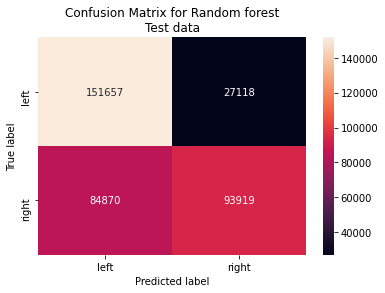


LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(max_iter=300, solver='saga')
train time: 16.682227611541748
test time:  0.017658710479736328
accuracy:   0.751
classification report:
              precision    recall  f1-score   support

        left       0.74      0.78      0.76    178775
       right       0.76      0.72      0.74    178789

    accuracy                           0.75    357564
   macro avg       0.75      0.75      0.75    357564
weighted avg       0.75      0.75      0.75    357564



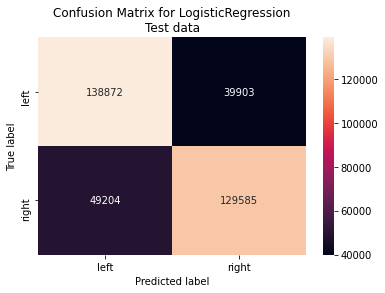


LinearSVC
________________________________________________________________________________
Training: 
LinearSVC()
train time: 18.509347677230835
test time:  0.01989436149597168
accuracy:   0.757
classification report:
              precision    recall  f1-score   support

        left       0.74      0.79      0.76    178775
       right       0.77      0.73      0.75    178789

    accuracy                           0.76    357564
   macro avg       0.76      0.76      0.76    357564
weighted avg       0.76      0.76      0.76    357564



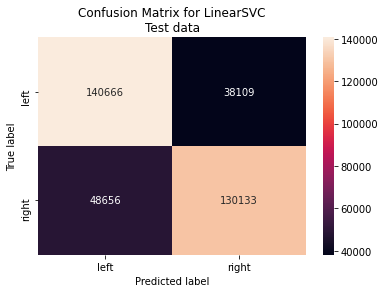


MultinomialNB
________________________________________________________________________________
Training: 
MultinomialNB()
train time: 0.19644403457641602
test time:  0.03741908073425293
accuracy:   0.743
classification report:
              precision    recall  f1-score   support

        left       0.74      0.76      0.75    178775
       right       0.75      0.73      0.74    178789

    accuracy                           0.74    357564
   macro avg       0.74      0.74      0.74    357564
weighted avg       0.74      0.74      0.74    357564



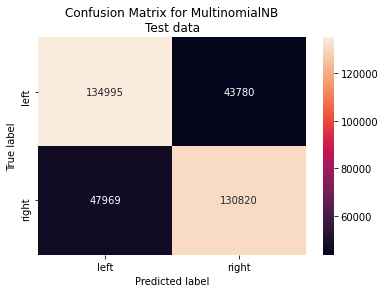


XGBClassifier
________________________________________________________________________________
Training: 
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
C:\Users\rzbe\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label

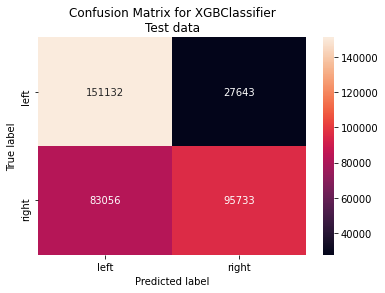


GradientBoostingClassifier
________________________________________________________________________________
Training: 
GradientBoostingClassifier()
train time: 657.7175378799438
test time:  0.41761279106140137
accuracy:   0.643
classification report:
              precision    recall  f1-score   support

        left       0.60      0.88      0.71    178775
       right       0.77      0.41      0.53    178789

    accuracy                           0.64    357564
   macro avg       0.69      0.64      0.62    357564
weighted avg       0.69      0.64      0.62    357564



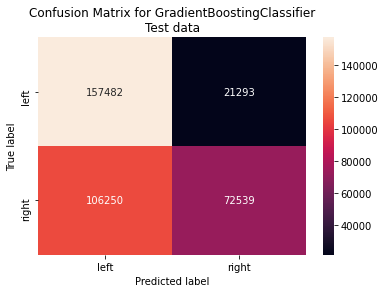


AdaBoostClassifier
________________________________________________________________________________
Training: 
AdaBoostClassifier()
train time: 163.76393866539001
test time:  3.7146077156066895
accuracy:   0.638
classification report:
              precision    recall  f1-score   support

        left       0.60      0.83      0.70    178775
       right       0.72      0.45      0.55    178789

    accuracy                           0.64    357564
   macro avg       0.66      0.64      0.63    357564
weighted avg       0.66      0.64      0.63    357564



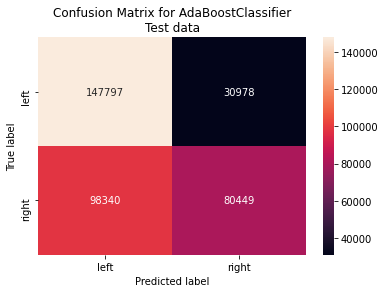


SGDClassifier
________________________________________________________________________________
Training: 
SGDClassifier()
train time: 1.985846757888794
test time:  0.018595218658447266
accuracy:   0.683
classification report:
              precision    recall  f1-score   support

        left       0.63      0.86      0.73    178775
       right       0.79      0.50      0.61    178789

    accuracy                           0.68    357564
   macro avg       0.71      0.68      0.67    357564
weighted avg       0.71      0.68      0.67    357564



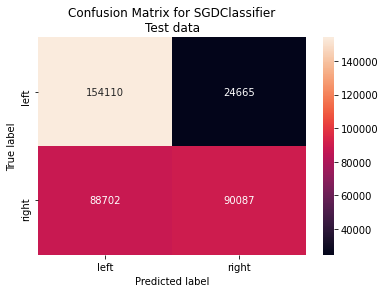

In [62]:
classifiers = [
           (SGDClassifier(), "SGDClassifier"),

           (AdaBoostClassifier(), "AdaBoostClassifier"),

           (GradientBoostingClassifier(), "GradientBoostingClassifier"),

           (XGBClassifier(), "XGBClassifier"),

           (MultinomialNB(), "MultinomialNB"),

           (LinearSVC(),"LinearSVC"),

           (LogisticRegression(max_iter=300,solver="saga"), "LogisticRegression"),

           (RandomForestClassifier(max_depth=50), "Random forest")
]
results = benchmark(classifiers[::-1],train_x_vectors, train_y, test_x_vectors, test_y)


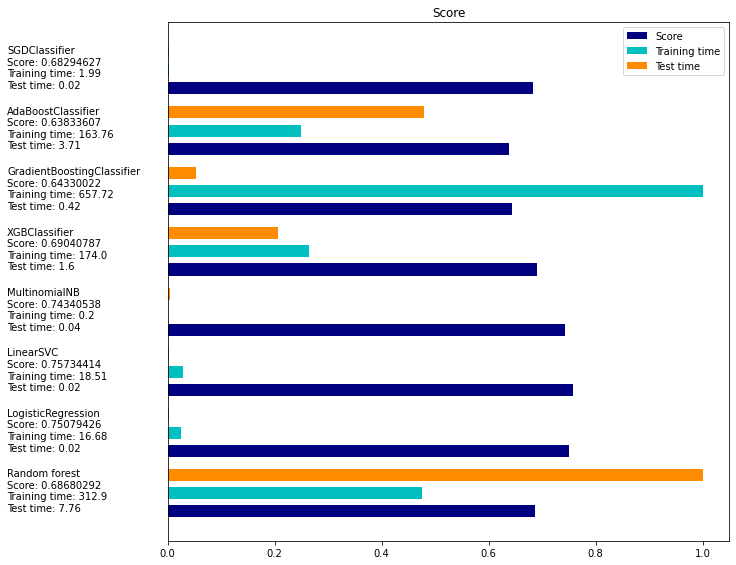

In [63]:
plt_clf(results)

## Parameter tuning with gridsearch

In [64]:
#Setting cross validation to 3
cv = 3
gridplot = True

### LinearSVC

Fitting 3 folds for each of 10 candidates, totalling 30 fits
____________________________________________________________________________________________________


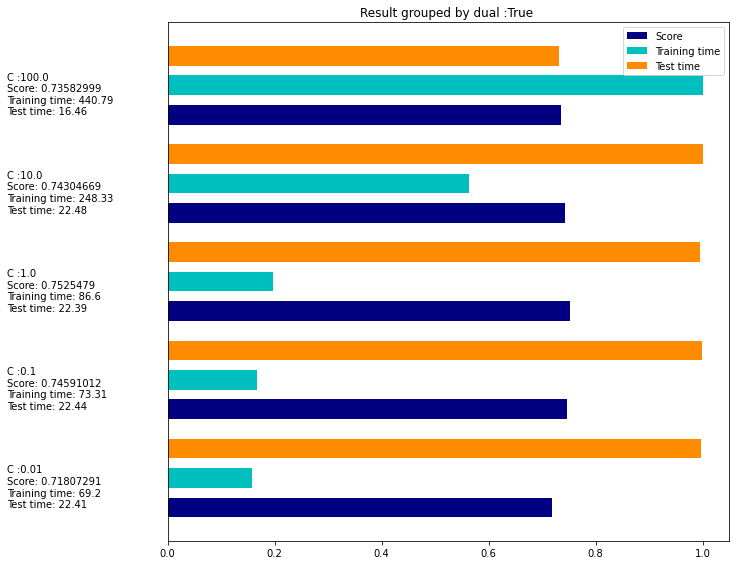

____________________________________________________________________________________________________
____________________________________________________________________________________________________


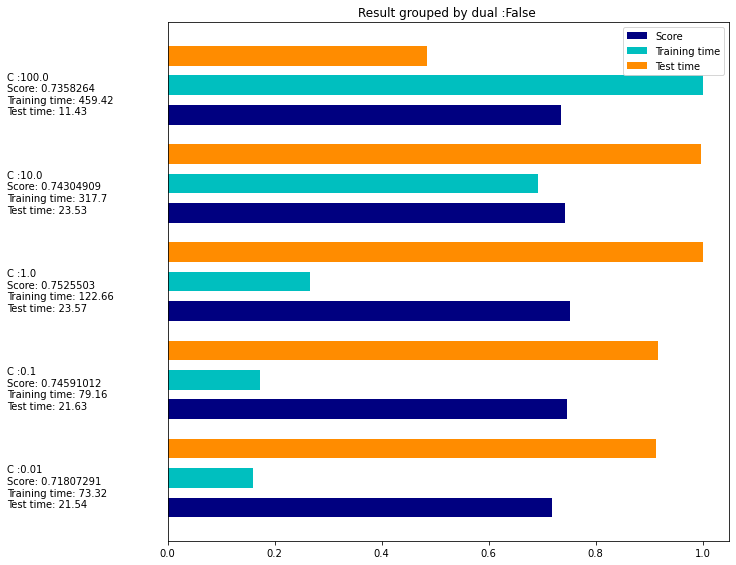

____________________________________________________________________________________________________
Best score: 0.75
Best parameters:  {'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'svc__C': 1.0, 'svc__dual': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Time: 0:20:28.061927


In [65]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("svc", LinearSVC())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "svc__dual": [True,False],
              "svc__C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}

LinearSVC_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### MultinomialNB

Fitting 3 folds for each of 3 candidates, totalling 9 fits
____________________________________________________________________________________________________


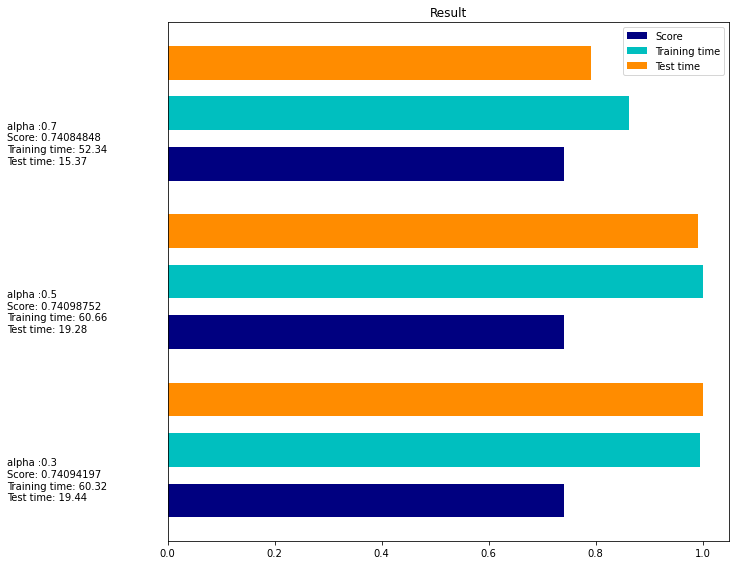

____________________________________________________________________________________________________
Best score: 0.74
Best parameters:  {'mnb__alpha': 0.5, 'mnb__fit_prior': True, 'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'tfidf__binary': True, 'tfidf__lowercase': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__tokenizer': <function whitespace_tokenizer at 0x000001F9A077AE50>, 'tfidf__use_idf': True}
Time: 0:03:26.037642


In [66]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("mnb", MultinomialNB())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__tokenizer": [whitespace_tokenizer],
              "tfidf__binary": [True],
              "tfidf__lowercase": [False],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "mnb__alpha": [0.3,0.5,0.7],
              "mnb__fit_prior": [True]}

MultinomialNB_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### LogisticRegression

Fitting 3 folds for each of 5 candidates, totalling 15 fits
____________________________________________________________________________________________________


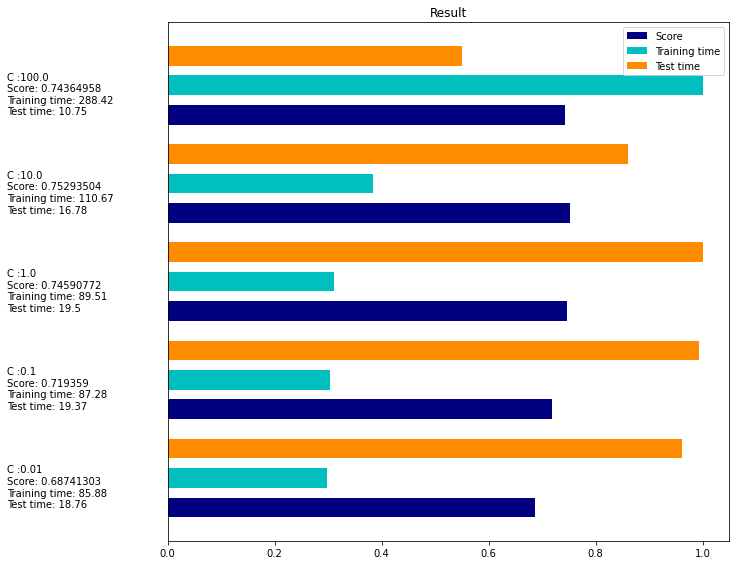

____________________________________________________________________________________________________
Best score: 0.75
Best parameters:  {'lr__C': 10.0, 'lr__max_iter': 300, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'select__k': 100000, 'select__score_func': <function chi2 at 0x000001F85D8D3940>, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Time: 0:09:28.277062


In [67]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("lr", LogisticRegression())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [100000],
              "lr__solver": ["saga"],
              "lr__penalty": ["l2"],
              "lr__C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
              "lr__max_iter":[300]}

LogisticRegression_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv,plot=gridplot)

### Results

LogisticRegression_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F9A077AE50>)),
                ('select',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x000001F85D8D3940>)),
                ('lr',
                 LogisticRegression(C=10.0, max_iter=300, solver='saga'))])
train time: 81.39333415031433
test time:  11.212080717086792
accuracy:   0.757
classification report:
              precision    recall  f1-score   support

        left       0.74      0.78      0.76    178775
       right       0.77      0.73      0.75    178789

    accuracy                           0.76    357564
   macro avg       0.76      0.76      0.76    357564
weighted avg    

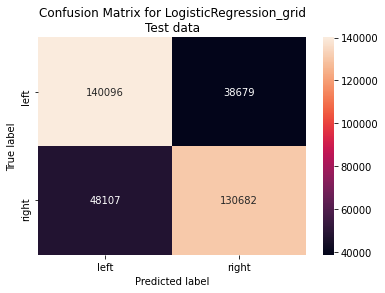


LinearSVC_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F9A077AE50>)),
                ('select',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x000001F85D8D3940>)),
                ('svc', LinearSVC(dual=False))])
train time: 103.61503171920776
test time:  12.096343755722046
accuracy:   0.757
classification report:
              precision    recall  f1-score   support

        left       0.74      0.79      0.76    178775
       right       0.77      0.73      0.75    178789

    accuracy                           0.76    357564
   macro avg       0.76      0.76      0.76    357564
weighted avg       0.76      0.76      0.76    357564



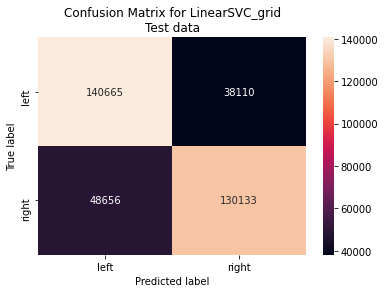


MultinomialNB_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F9A077AE50>,
                                 use_idf=False)),
                ('select',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x000001F85D8D3940>)),
                ('mnb', MultinomialNB(alpha=0.5))])
train time: 35.32367825508118
test time:  9.410883665084839
accuracy:   0.743
classification report:
              precision    recall  f1-score   support

        left       0.73      0.76      0.75    178775
       right       0.75      0.72      0.74    178789

    accuracy                           0.74    357564
   macro avg       0.74      0.74      0.74    357564
weighte

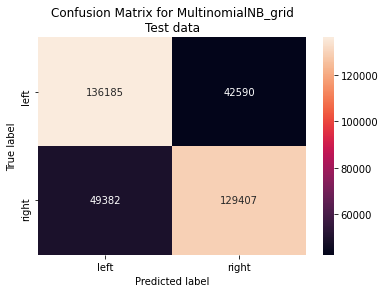

In [68]:
classifiers_grid = [
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True,use_idf=False,binary=True)),
                  ("select", SelectKBest(chi2, k = 100000)),
                  ("mnb", MultinomialNB(**MultinomialNB_grid))
                  ])),"MultinomialNB_grid"),
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)),
                  ("select", SelectKBest(chi2, k = 100000)),
                  ("svc", LinearSVC(**LinearSVC_grid))
                  ])),"LinearSVC_grid"),
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)),
                  ("select", SelectKBest(chi2, k = 100000)),
                  ("lr", LogisticRegression(**LogisticRegression_grid))
                  ])),"LogisticRegression_grid")
               ]
results_grid = benchmark(classifiers_grid[::-1],train_x, train_y, test_x, test_y)

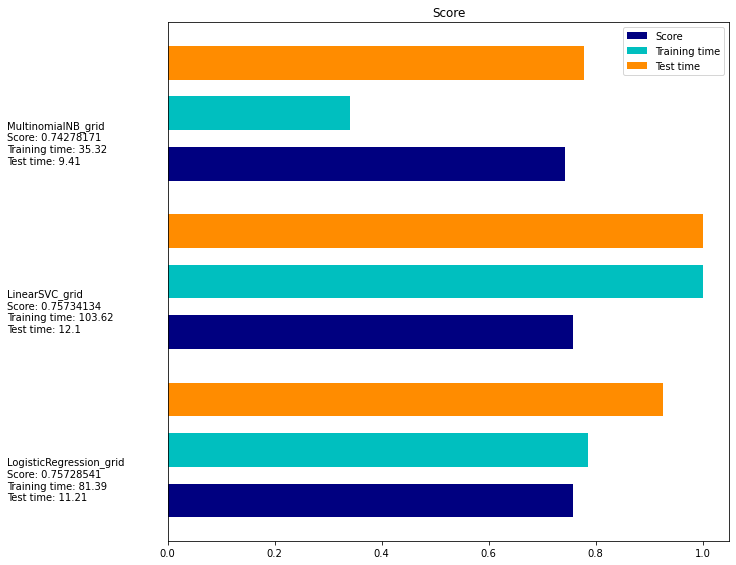

In [69]:
plt_clf(results_grid)

## Combining columns status_message and link name for classification

In [69]:
col = "link and message"
df = df_link_message

In [70]:
train_x, test_x, train_y, test_y = train_test_split(df[col],df["target"], test_size=0.2, random_state=101, shuffle=True,stratify=df["target"])

In [71]:
stopwatch = datetime.now()

vectorizer = TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)#, binary=True)
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

total_features = train_x_vectors.shape[1]
max_features = 1000000
selector = SelectKBest(chi2, k = max_features)
train_x_vectors = selector.fit_transform(train_x_vectors, train_y)
test_x_vectors = selector.transform(test_x_vectors)

#feature_names = vectorizer.get_feature_names()
#feature_names = np.asarray([feature_names[i] for i in selector.get_support(indices=True)])

print(f"fit & transform, selecting top the {max_features} of {total_features} features")
print(f"Time: {datetime.now() - stopwatch}")

fit & transform, selecting top the 1000000 of 4000732 features
Time: 0:01:25.058766


Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(max_depth=50)
train time: 769.7456676959991
test time:  11.85221529006958
accuracy:   0.731
classification report:
              precision    recall  f1-score   support

        left       0.76      0.67      0.71    146438
       right       0.70      0.79      0.75    146438

    accuracy                           0.73    292876
   macro avg       0.73      0.73      0.73    292876
weighted avg       0.73      0.73      0.73    292876



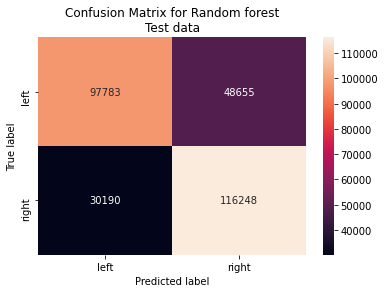


LogisticRegression
________________________________________________________________________________
Training: 
LogisticRegression(max_iter=300, solver='saga')
train time: 45.25849652290344
test time:  0.03796839714050293
accuracy:   0.802
classification report:
              precision    recall  f1-score   support

        left       0.79      0.83      0.81    146438
       right       0.82      0.78      0.80    146438

    accuracy                           0.80    292876
   macro avg       0.80      0.80      0.80    292876
weighted avg       0.80      0.80      0.80    292876



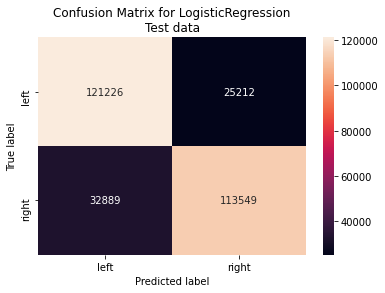


LinearSVC
________________________________________________________________________________
Training: 
LinearSVC()
train time: 30.695331811904907
test time:  0.0398106575012207
accuracy:   0.813
classification report:
              precision    recall  f1-score   support

        left       0.80      0.83      0.82    146438
       right       0.83      0.79      0.81    146438

    accuracy                           0.81    292876
   macro avg       0.81      0.81      0.81    292876
weighted avg       0.81      0.81      0.81    292876



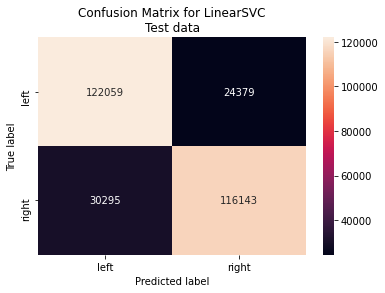


MultinomialNB
________________________________________________________________________________
Training: 
MultinomialNB()
train time: 0.9060549736022949
test time:  0.15399813652038574
accuracy:   0.789
classification report:
              precision    recall  f1-score   support

        left       0.76      0.84      0.80    146438
       right       0.82      0.73      0.78    146438

    accuracy                           0.79    292876
   macro avg       0.79      0.79      0.79    292876
weighted avg       0.79      0.79      0.79    292876



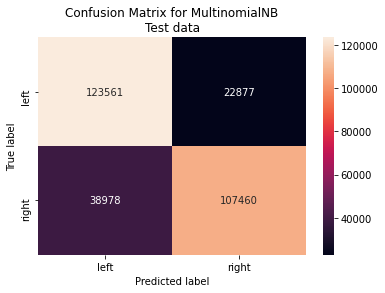


XGBClassifier
________________________________________________________________________________
Training: 
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
C:\Users\rzbe\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label

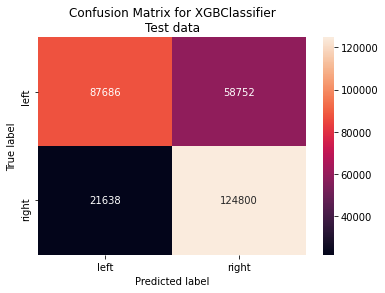


GradientBoostingClassifier
________________________________________________________________________________
Training: 
GradientBoostingClassifier()
train time: 2234.5798799991608
test time:  0.4129452705383301
accuracy:   0.660
classification report:
              precision    recall  f1-score   support

        left       0.71      0.53      0.61    146438
       right       0.63      0.79      0.70    146438

    accuracy                           0.66    292876
   macro avg       0.67      0.66      0.65    292876
weighted avg       0.67      0.66      0.65    292876



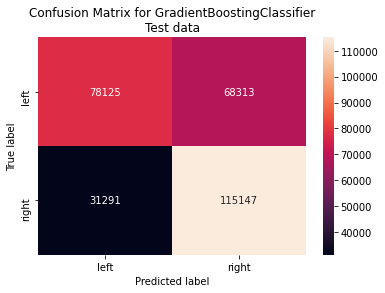


AdaBoostClassifier
________________________________________________________________________________
Training: 
AdaBoostClassifier()
train time: 511.9326100349426
test time:  5.452828884124756
accuracy:   0.636
classification report:
              precision    recall  f1-score   support

        left       0.72      0.44      0.55    146438
       right       0.60      0.83      0.69    146438

    accuracy                           0.64    292876
   macro avg       0.66      0.64      0.62    292876
weighted avg       0.66      0.64      0.62    292876



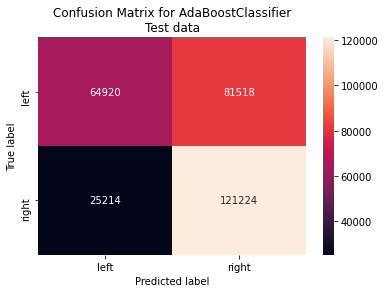


SGDClassifier
________________________________________________________________________________
Training: 
SGDClassifier()
train time: 4.791501522064209
test time:  0.035364389419555664
accuracy:   0.731
classification report:
              precision    recall  f1-score   support

        left       0.70      0.80      0.75    146438
       right       0.77      0.67      0.71    146438

    accuracy                           0.73    292876
   macro avg       0.73      0.73      0.73    292876
weighted avg       0.73      0.73      0.73    292876



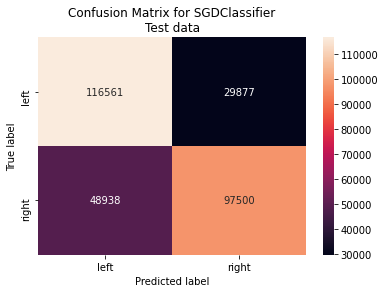

In [72]:
classifiers = [
           (SGDClassifier(), "SGDClassifier"),

           (AdaBoostClassifier(), "AdaBoostClassifier"),

           (GradientBoostingClassifier(), "GradientBoostingClassifier"),

           (XGBClassifier(), "XGBClassifier"),

           (MultinomialNB(), "MultinomialNB"),

           (LinearSVC(),"LinearSVC"),

           (LogisticRegression(max_iter=300,solver="saga"), "LogisticRegression"),

           (RandomForestClassifier(max_depth=50), "Random forest")
]
results = benchmark(classifiers[::-1],train_x_vectors, train_y, test_x_vectors, test_y)

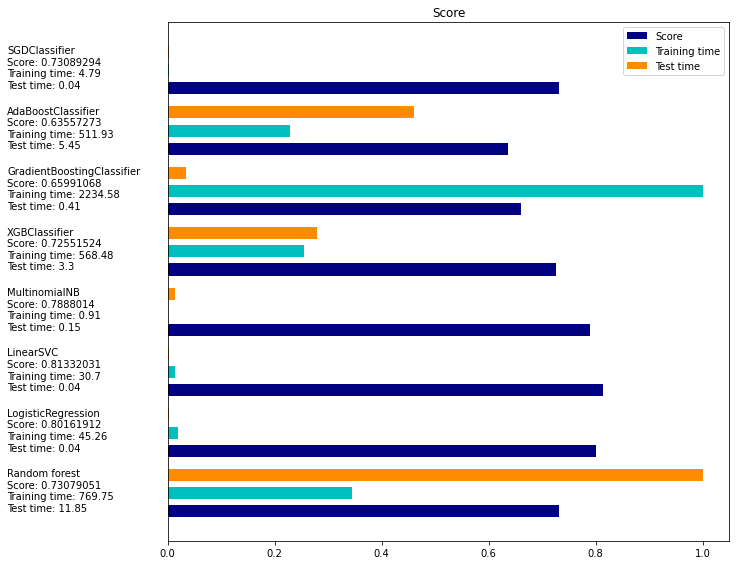

In [73]:
plt_clf(results)

## Parameter tuning with gridsearch

In [74]:
#Setting cross validation to 3
cv = 3
gridplot = True

### LinearSVC

Fitting 3 folds for each of 10 candidates, totalling 30 fits
____________________________________________________________________________________________________


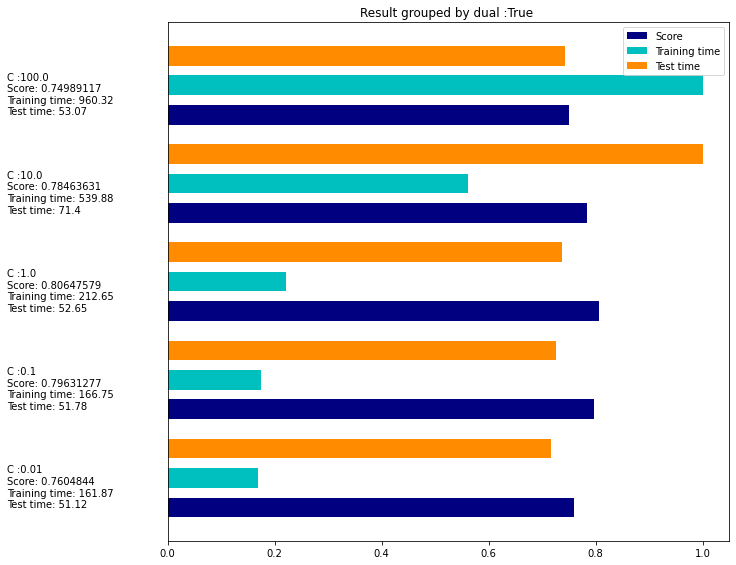

____________________________________________________________________________________________________
____________________________________________________________________________________________________


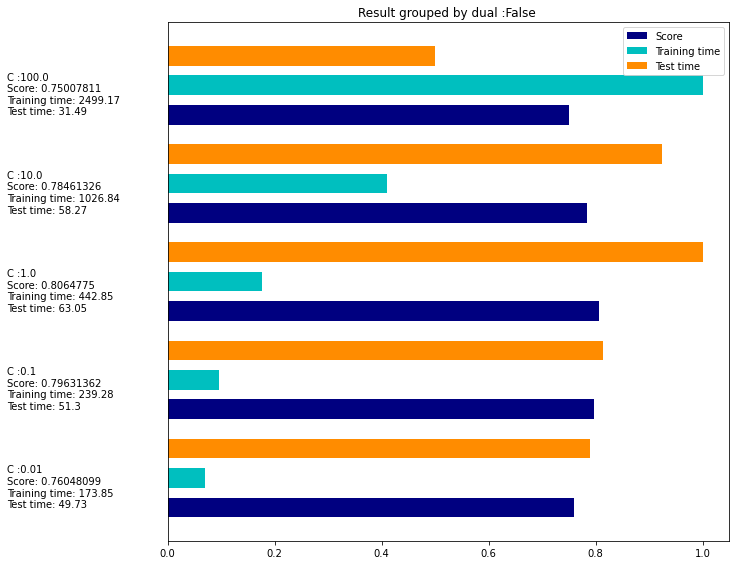

____________________________________________________________________________________________________
Best score: 0.81
Best parameters:  {'select__k': 1000000, 'select__score_func': <function chi2 at 0x000001F1B7C98940>, 'svc__C': 1.0, 'svc__dual': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Time: 1:17:39.235526


In [75]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("svc", LinearSVC())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [max_features],
              "svc__dual": [True,False],
              "svc__C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}

LinearSVC_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### MultinomialNB

Fitting 3 folds for each of 3 candidates, totalling 9 fits
____________________________________________________________________________________________________


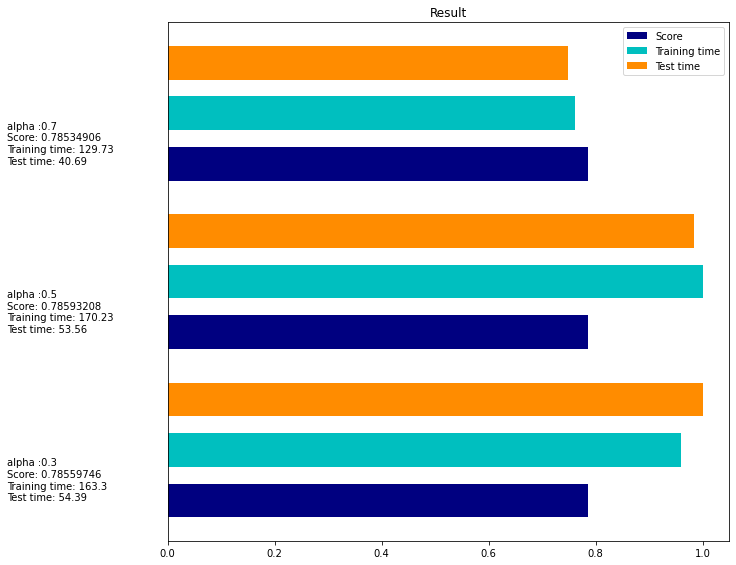

____________________________________________________________________________________________________
Best score: 0.79
Best parameters:  {'mnb__alpha': 0.5, 'mnb__fit_prior': True, 'select__k': 1000000, 'select__score_func': <function chi2 at 0x000001F1B7C98940>, 'tfidf__binary': True, 'tfidf__lowercase': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__tokenizer': <function whitespace_tokenizer at 0x000001F2C91E6790>, 'tfidf__use_idf': True}
Time: 0:08:59.860838


In [76]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("mnb", MultinomialNB())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__tokenizer": [whitespace_tokenizer],
              "tfidf__binary": [True],
              "tfidf__lowercase": [False],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [max_features],
              "mnb__alpha": [0.3,0.5,0.7],
              "mnb__fit_prior": [True]}

MultinomialNB_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### BernoulliNB

Fitting 3 folds for each of 3 candidates, totalling 9 fits
____________________________________________________________________________________________________


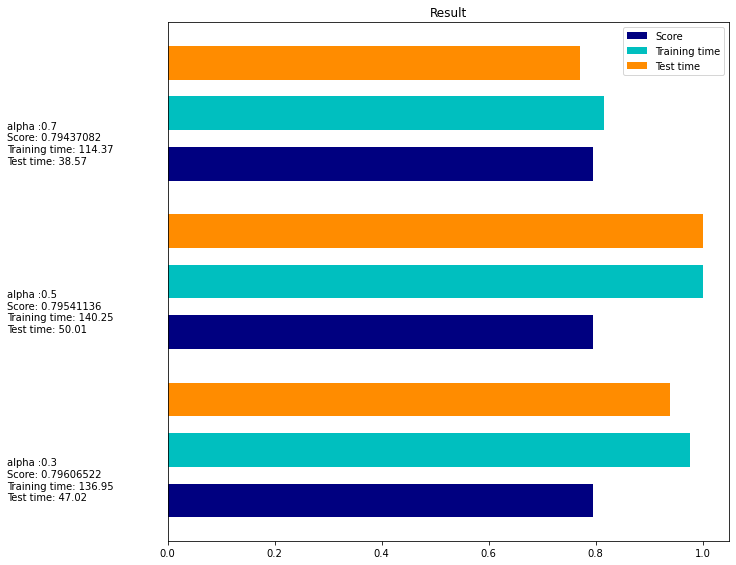

____________________________________________________________________________________________________
Best score: 0.80
Best parameters:  {'mnb__alpha': 0.3, 'mnb__fit_prior': True, 'select__k': 1000000, 'select__score_func': <function chi2 at 0x000001F1B7C98940>, 'tfidf__binary': True, 'tfidf__lowercase': False, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__tokenizer': <function whitespace_tokenizer at 0x000001F2C91E6790>, 'tfidf__use_idf': True}
Time: 0:07:56.433055


In [77]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("mnb", BernoulliNB())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__tokenizer": [whitespace_tokenizer],
              "tfidf__binary": [True],
              "tfidf__lowercase": [False],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [max_features],
              "mnb__alpha": [0.3,0.5,0.7],
              "mnb__fit_prior": [True]}

BernoulliNB_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv, plot=gridplot)

### LogisticRegression

Fitting 3 folds for each of 5 candidates, totalling 15 fits
____________________________________________________________________________________________________


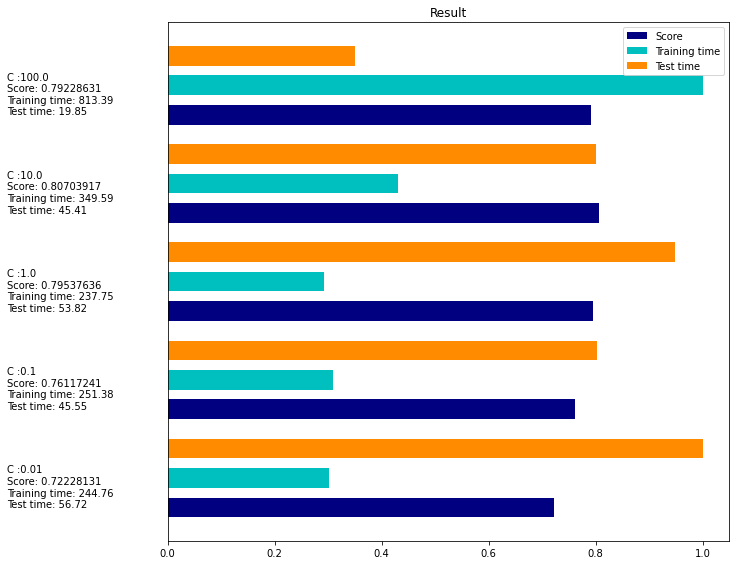

____________________________________________________________________________________________________
Best score: 0.81
Best parameters:  {'lr__C': 10.0, 'lr__max_iter': 300, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'select__k': 1000000, 'select__score_func': <function chi2 at 0x000001F1B7C98940>, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Time: 0:24:50.883553


In [78]:
pipeline = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(tokenizer=whitespace_tokenizer,lowercase=False)),
  ("select", SelectKBest()),
  ("lr", LogisticRegression())
  ])

parameters = {"tfidf__ngram_range": [(1,2)],
              "tfidf__sublinear_tf": [True],
              "tfidf__use_idf": [True],
              "select__score_func": [chi2],
              "select__k": [max_features],
              "lr__solver": ["saga"],
              "lr__penalty": ["l2"],
              "lr__C": [1e-2, 1e-1, 1e0, 1e1, 1e2],
              "lr__max_iter":[300]}

LogisticRegression_grid = gridsearch(pipeline,parameters,train_x,train_y, cv = cv,plot=gridplot)

### Results

LogisticRegression_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F2C91E6790>)),
                ('select',
                 SelectKBest(k=1000000,
                             score_func=<function chi2 at 0x000001F1B7C98940>)),
                ('lr',
                 LogisticRegression(C=10.0, max_iter=300, solver='saga'))])
train time: 154.7422411441803
test time:  11.698383092880249
accuracy:   0.814
classification report:
              precision    recall  f1-score   support

        left       0.80      0.84      0.82    146438
       right       0.83      0.79      0.81    146438

    accuracy                           0.81    292876
   macro avg       0.81      0.81      0.81    292876
weighted avg   

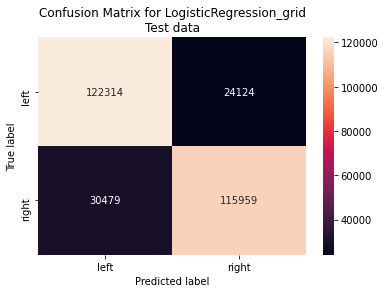


LinearSVC_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F2C91E6790>)),
                ('select',
                 SelectKBest(k=1000000,
                             score_func=<function chi2 at 0x000001F1B7C98940>)),
                ('svc', LinearSVC(dual=False))])
train time: 304.9397165775299
test time:  10.998902082443237
accuracy:   0.813
classification report:
              precision    recall  f1-score   support

        left       0.80      0.83      0.82    146438
       right       0.83      0.79      0.81    146438

    accuracy                           0.81    292876
   macro avg       0.81      0.81      0.81    292876
weighted avg       0.81      0.81      0.81    292876



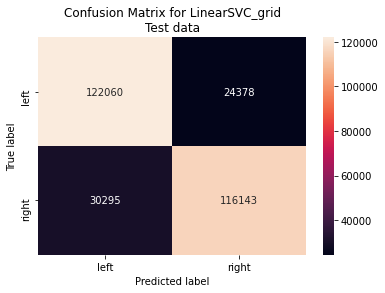


MultinomialNB_grid
________________________________________________________________________________
Training: 
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function whitespace_tokenizer at 0x000001F2C91E6790>,
                                 use_idf=False)),
                ('select',
                 SelectKBest(k=1000000,
                             score_func=<function chi2 at 0x000001F1B7C98940>)),
                ('mnb', MultinomialNB(alpha=0.5))])
train time: 55.801066875457764
test time:  8.976275444030762
accuracy:   0.788
classification report:
              precision    recall  f1-score   support

        left       0.77      0.83      0.80    146438
       right       0.82      0.75      0.78    146438

    accuracy                           0.79    292876
   macro avg       0.79      0.79      0.79    292876
weigh

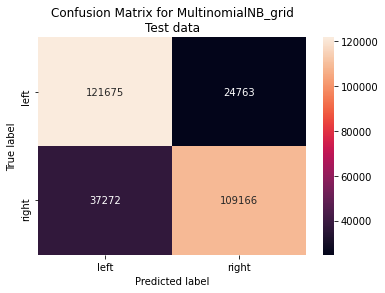

In [79]:
classifiers_grid = [
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True,use_idf=False,binary=True)),
                  ("select", SelectKBest(chi2, k = max_features)),
                  ("mnb", MultinomialNB(**MultinomialNB_grid))
                  ])),"MultinomialNB_grid"),
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)),
                  ("select", SelectKBest(chi2, k = max_features)),
                  ("svc", LinearSVC(**LinearSVC_grid))
                  ])),"LinearSVC_grid"),
               
               ((Pipeline([
                  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False ,sublinear_tf=True)),
                  ("select", SelectKBest(chi2, k = max_features)),
                  ("lr", LogisticRegression(**LogisticRegression_grid))
                  ])),"LogisticRegression_grid")
               ]
results_grid = benchmark(classifiers_grid[::-1],train_x, train_y, test_x, test_y)

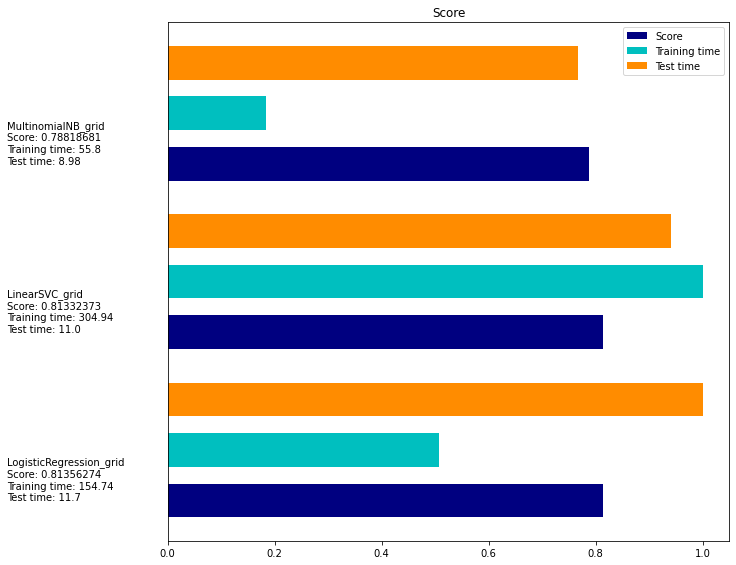

In [80]:
plt_clf(results_grid)

## Statistical Significance test

### Logistic regression vs. Linear SVC

In [82]:

#Comparing two candidate classifiers using paired Student-t test. Assumption of sample independence is violated due to cross validation, however this method is still very modest against type 2 error
stopwatch = datetime.now()

candidate1 = LinearSVC(**LinearSVC_grid)
candidate2 = LogisticRegression(**LogisticRegression_grid)

#pipelines to avoid data leakage

pipeline1 = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False,sublinear_tf=True)),
  ("select", SelectKBest(chi2, k = max_features)),
  ("candidate1", candidate1)
  ])

pipeline2 = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False,sublinear_tf=True)),
  ("select", SelectKBest(chi2, k = max_features)),
  ("candidate2", candidate2)
  ])

#require at least 20 results for normality test below

Kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=15450)

scores1 = cross_val_score(pipeline1, X=train_x, y=train_y, cv=Kfold, n_jobs=-1, verbose=1, scoring = 'accuracy')
scores2 = cross_val_score(pipeline2, X=train_x, y=train_y, cv=Kfold, n_jobs=-1, verbose=1, scoring = 'accuracy')

# Defining: "H0 hypotesis: both score samples are drawn from the same population, no significant difference between the score means, hence cannot conclude that one candidate is better than another one based on the test"

#Checking first if scores are normally distributed

v1, p1 = normaltest(scores1)
v2, p2 = normaltest(scores2)
if p1 > 0.05 and p2 > 0.05:
    print(f"Results from both candidates are normally distributed")
    val, p_sst = ttest_rel(scores1, scores2)
    if p_sst > 0.05:
        print(f"Failed to reject H0, cannot conclude if one candidate is better than another")
    else:
        print(f"Reject H0, there is more than {(1 - p_sst)*100} probability that score samples are significantly different. {candidate1 if np.mean(scores1) > np.mean(scores2) else candidate2} gives better results")

elif p1 < 0.05 and p2 < 0.05:

        #Both score sets are not normally distributed, can use Wilcoxon test to check significance
        print(f"Results from both candidates are NOT normally distributed")
        val, p_sst = wilcoxon(scores1, scores2)
        if p_sst > 0.05:
            print(f"Failed to reject H0, cannot conclude if one candidate is better than another")
        else:
            print(f"Reject H0, there is more than {(1 - p_sst)*100} probability that score samples are significantly different. {candidate1 if np.mean(scores1) > np.mean(scores2) else candidate2} gives better results")
    #else:
        #print(f"Results from {candidate2} are NOT normally distributed")
print(f"Time: {datetime.now() - stopwatch}")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
# Statistical significance test using 5x2 fold validation
stopwatch = datetime.now()

v52, p52 = paired_ttest_5x2cv(estimator1=pipeline1, estimator2=pipeline2, X=train_x, y=train_y, scoring='accuracy', random_seed=1)

if p52 > 0.05:
    print(f"Failed to reject H0, cannot conclude if one candidate is better than another")
else:
    print(f"Reject H0, there is more than {(1 - p52)*100} probability that score samples are significantly different. {candidate1 if np.mean(scores1) > np.mean(scores2) else candidate2} gives better results")

print(f"Time: {datetime.now() - stopwatch}")

### Multinomial Bayes vs. Linear SVC

In [ ]:
#Comparing two candidate classifiers using paired Student-t test. Assumption of sample independence is violated due to cross validation, however this method is still very modest against type 2 error
stopwatch = datetime.now()

candidate1 = LinearSVC(**LinearSVC_grid)
candidate2 = MultinomialNB(**MultinomialNB_grid)

#pipelines to avoid data leakage

pipeline1 = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False,sublinear_tf=True)),
  ("select", SelectKBest(chi2, k = max_features)),
  ("candidate1", candidate1)
  ])

pipeline2 = Pipeline(steps=[
  ("tfidf", TfidfVectorizer(ngram_range=(1, 2),tokenizer=whitespace_tokenizer,lowercase=False,sublinear_tf=True)),
  ("select", SelectKBest(chi2, k = max_features)),
  ("candidate2", candidate2)
  ])

#require at least 20 results for normality test below

Kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=15450)

scores1 = cross_val_score(pipeline1, X=train_x, y=train_y, cv=Kfold, n_jobs=-1, verbose=1, scoring = 'accuracy')
scores2 = cross_val_score(pipeline2, X=train_x, y=train_y, cv=Kfold, n_jobs=-1, verbose=1, scoring = 'accuracy')

# Defining: "H0 hypotesis: both score samples are drawn from the same population, no significant difference between the score means, hence cannot conclude that one candidate is better than another one based on the test"

#Checking first if scores are normally distributed

v1, p1 = normaltest(scores1)
v2, p2 = normaltest(scores2)
if p1 > 0.05 and p2 > 0.05:
    print(f"Results from both candidates are normally distributed")
    val, p_sst = ttest_rel(scores1, scores2)
    if p_sst > 0.05:
        print(f"Failed to reject H0, cannot conclude if one candidate is better than another")
    else:
        print(f"Reject H0, there is more than {(1 - p_sst)*100} probability that score samples are significantly different. {candidate1 if np.mean(scores1) > np.mean(scores2) else candidate2} gives better results")

elif p1 < 0.05 and p2 < 0.05:

        #Both score sets are not normally distributed, can use Wilcoxon test to check significance
        print(f"Results from both candidates are NOT normally distributed")
        val, p_sst = wilcoxon(scores1, scores2)
        if p_sst > 0.05:
            print(f"Failed to reject H0, cannot conclude if one candidate is better than another")
        else:
            print(f"Reject H0, there is more than {(1 - p_sst)*100} probability that score samples are significantly different. {candidate1 if np.mean(scores1) > np.mean(scores2) else candidate2} gives better results")
    #else:
        #print(f"Results from {candidate2} are NOT normally distributed")
print(f"Time: {datetime.now() - stopwatch}")

In [ ]:
# Statistical significance test using 5x2 fold validation
stopwatch = datetime.now()

v52, p52 = paired_ttest_5x2cv(estimator1=pipeline1, estimator2=pipeline2, X=train_x, y=train_y, scoring='accuracy', random_seed=1)

if p52 > 0.05:
    print(f"Failed to reject H0, cannot conclude if one candidate is better than another")
else:
    print(f"Reject H0, there is more than {(1 - p52)*100} probability that score samples are significantly different. {candidate1 if np.mean(scores1) > np.mean(scores2) else candidate2} gives better results")

print(f"Time: {datetime.now() - stopwatch}")